### Library Import

In [23]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from typing import List, Dict
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 파일 호출
data_path: str = "/content/drive/MyDrive/AI Tech/프로젝트/Level 1. 비트코인 상승하락 시계열 분류 예측/data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [4]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

100%|██████████| 107/107 [00:08<00:00, 13.21it/s]


## Network Data 추출

In [5]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
    'hourly_network-data_block-interval_block_interval':'block_interval',
    'hourly_network-data_block-count_block_count':'block_count',
    'hourly_network-data_block-bytes_block_bytes':'block_bytes',
    'hourly_network-data_blockreward_blockreward':'blockreward',
    'hourly_network-data_transactions-count_transactions_count_total': 'transaction_count',
    'hourly_network-data_tokens-transferred_tokens_transferred_total': 'token_transferred',
    'hourly_network-data_tokens-transferred_tokens_transferred_mean':
    'token_transferred_mean',
    'hourly_network-data_tokens-transferred_tokens_transferred_median':
    'token_transferred_median',
    'hourly_network-data_hashrate_hashrate':
    'hashrate',
    'hourly_network-data_difficulty_difficulty':
    'difficulty',
    'hourly_network-data_fees-transaction_fees_transaction_mean':
    'fees_transaction',
    'hourly_network-data_fees_fees_total':
    'fees',
    'hourly_network-data_velocity_velocity_supply_total':
    'velocity_supply',
    'hourly_network-data_utxo-count_utxo_count':
    'utxo_count',
    'hourly_network-data_supply_supply_total':
    'supply_total',
    'hourly_network-data_supply_supply_new':
    'supply_new',
    'hourly_network-data_fees_fees_block_mean':
    'fees_block_mean',
    'hourly_network-data_fees-transaction_fees_transaction_median':
    'fees_transaction_median',
}

df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape


(11552, 34)

In [6]:
# 'hourly_network'로 시작하는 열 이름을 필터링
hourly_network_columns = [col for col in cols_dict.keys() if col.startswith('hourly_network')]

# 해당 열만 추출하여 새로운 데이터프레임 생성
df_hourly_network = df[['ID',"_type","target","active_count","receiver_count","sender_count",'block_interval','block_count','block_bytes','blockreward','transaction_count','token_transferred','token_transferred_mean','token_transferred_median','hashrate','difficulty','fees_transaction','fees','velocity_supply','utxo_count','supply_total','supply_new','fees_block_mean','fees_transaction_median']]

# 결과 확인
df_hourly_network.head()

ID  _type  target  active_count  receiver_count  \
0  2023-01-01 00:00:00  train     2.0         67987           37752   
1  2023-01-01 01:00:00  train     1.0         30593           20534   
2  2023-01-01 02:00:00  train     1.0         33897           19369   
3  2023-01-01 03:00:00  train     1.0         32717           23799   
4  2023-01-01 04:00:00  train     2.0         45176           31712   

   sender_count  block_interval  block_count    block_bytes  blockreward  ...  \
0         37307      427.333333         12.0  783554.416667    75.561037  ...   
1         12342      782.500000          4.0  890760.500000    25.256248  ...   
2         17737      365.125000          8.0  558209.750000    50.312978  ...   
3         11421      667.800000          5.0  640371.800000    31.469829  ...   
4         17320      703.000000          7.0  712739.000000    44.094866  ...   

       hashrate    difficulty  fees_transaction      fees  velocity_supply  \
0  5.062917e+11  3.536407e+13          0.000049  0.561037        65.978971   
1  1.687639e+11  3.536407e+13          0.000044  0.256248        65.977755   
2  3.375278e+11  3.536407e+13          0.000056  0.312978        65.975570   
3  2.109549e+11  3.536407e+13          0.000042  0.219829        65.975092   
4  2.953368e+11  3.536407e+13          0.000050  0.344866        65.969825   

   utxo_count  supply_total  supply_new  fees_block_mean  \
0  83308092.0  1.924871e+07       75.00         0.046753   
1  83314883.0  1.924874e+07       25.00         0.064062   
2  83314090.0  1.924879e+07       50.00         0.039122   
3  83326258.0  1.924882e+07       31.25         0.043966   
4  83339168.0  1.924886e+07       43.75         0.049267   

   fees_transaction_median  
0                 0.000014  
1                 0.000014  
2                 0.000014  
3                 0.000014  
4                 0.000014  

[5 rows x 24 columns]

## Network Data 결측치 탐색

In [7]:
eda_df = df_hourly_network.loc[df_hourly_network["_type"] == "train"]
# 각 열에서 누락된 값의 수를 계산
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

token_transferred_mean      0.216895
fees_block_mean             0.216895
block_interval              0.216895
block_bytes                 0.216895
fees_transaction            0.216895
difficulty                  0.216895
token_transferred_median    0.000000
supply_new                  0.000000
supply_total                0.000000
utxo_count                  0.000000
velocity_supply             0.000000
fees                        0.000000
hashrate                    0.000000
ID                          0.000000
_type                       0.000000
token_transferred           0.000000
transaction_count           0.000000
blockreward                 0.000000
block_count                 0.000000
sender_count                0.000000
receiver_count              0.000000
active_count                0.000000
target                      0.000000
fees_transaction_median     0.000000
dtype: float64

token_transferred_mean, fees_block_mean, block_interval, block_bytes, fees_transaction, difficulty 총 5개의 컬럼에 약 21%의 결측치가 있는 것을 발견했습니다. 데이터의 분포를 확인한 후에 결측치를 어떻게 처리할지 결정하겠습니다.

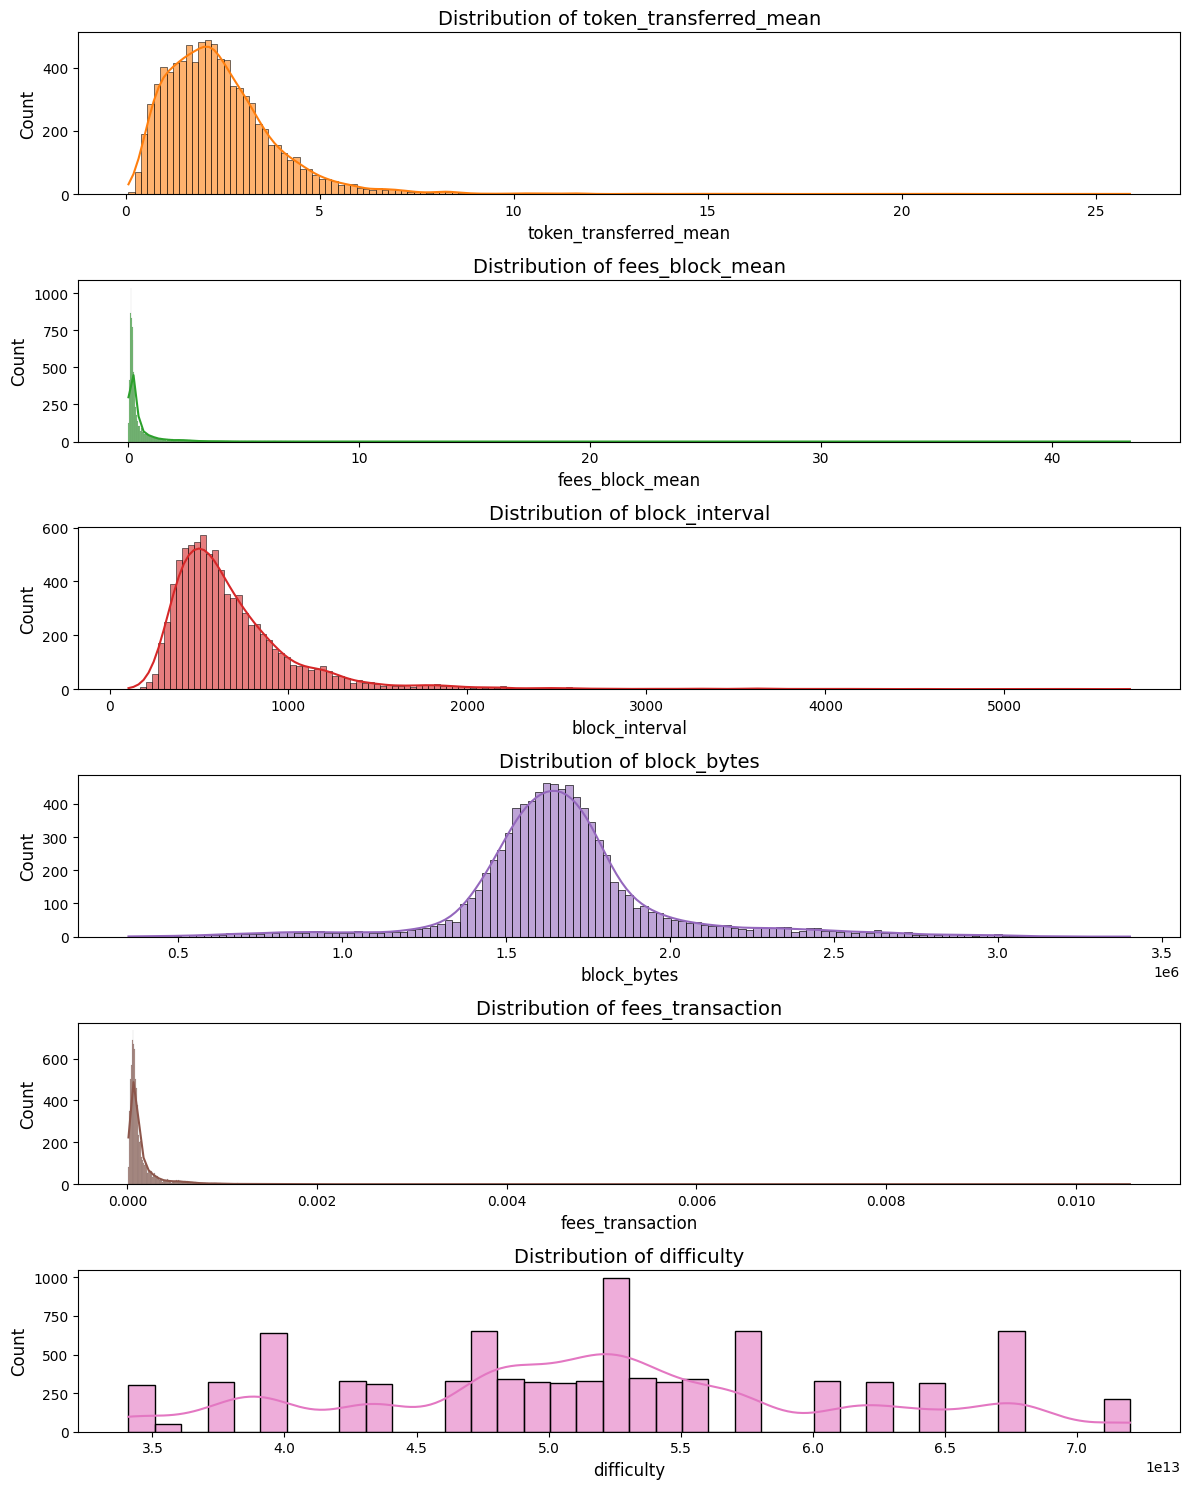

In [8]:
# 히스토그램을 그릴 컬럼 목록
columns_to_plot = ['token_transferred_mean', 'fees_block_mean', 'block_interval', 'block_bytes', 'fees_transaction', 'difficulty']

# 그래프 크기 설정
plt.figure(figsize=(12, 15))

# 각 컬럼별 히스토그램 생성
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(len(columns_to_plot), 1, i)  # 여러 서브플롯 생성
    sns.histplot(eda_df[col].dropna(), kde=True, color=f"C{i}", label=col, alpha=0.6)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)

# 그래프 간 여백을 자동으로 조정
plt.tight_layout()

# 그래프 표시
plt.show()

그래프를 통해서 block_bytes와 difficulty를 제외한 경우 우측으로 긴꼬리를 가지는 것을 알 수 있었다. 분포를 고려했을 때 block_bytes와 difficulty를 제외한 경우 중앙값으로 대체할 수 있고 나머지는 평균을 활용할 수 있습니다.

하지만 변수의 특성을 함께 고려했을 때 block_interval과 difficulty의 경우 시간에 따라 변화하는 특징을 지니므로 선형 보간으로 결측치를 처리하였습니다.

In [9]:
# 선형 보간을 적용할 컬럼
columns_to_interpolate = ['block_interval', 'difficulty']

# 중앙값으로 대체할 컬럼
columns_to_fill_median = ['token_transferred_mean', 'fees_block_mean', 'fees_transaction']

# 선형 보간 적용
eda_df[columns_to_interpolate] = eda_df[columns_to_interpolate].interpolate(method='linear')

# 중앙값으로 결측치 대체
for col in columns_to_fill_median:
    eda_df[col].fillna(eda_df[col].median(), inplace=True)

# 평균으로 결측치 대체
eda_df['block_bytes'].fillna(eda_df['block_bytes'].mean(), inplace=True)

<ipython-input-9-6aae0cc25f23>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_df[columns_to_interpolate] = eda_df[columns_to_interpolate].interpolate(method='linear')
<ipython-input-9-6aae0cc25f23>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_df[col].fillna(eda_df[col].median(), inplace=True)
<ipython-input-9-6aae0cc25f23>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [10]:
# 각 열에서 누락된 값의 수를 계산
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

ID                          0.0
_type                       0.0
fees_block_mean             0.0
supply_new                  0.0
supply_total                0.0
utxo_count                  0.0
velocity_supply             0.0
fees                        0.0
fees_transaction            0.0
difficulty                  0.0
hashrate                    0.0
token_transferred_median    0.0
token_transferred_mean      0.0
token_transferred           0.0
transaction_count           0.0
blockreward                 0.0
block_bytes                 0.0
block_count                 0.0
block_interval              0.0
sender_count                0.0
receiver_count              0.0
active_count                0.0
target                      0.0
fees_transaction_median     0.0
dtype: float64

In [11]:
# _type이 'train'인 데이터만 필터링하고 ID 열 제거
eda_df_train = eda_df[eda_df['_type'] == 'train'].drop(columns=['ID'])
eda_df_train = eda_df_train.drop(columns=['_type'])
# 결과 확인
eda_df_train.head()

target  active_count  receiver_count  sender_count  block_interval  \
0     2.0         67987           37752         37307      427.333333   
1     1.0         30593           20534         12342      782.500000   
2     1.0         33897           19369         17737      365.125000   
3     1.0         32717           23799         11421      667.800000   
4     2.0         45176           31712         17320      703.000000   

   block_count    block_bytes  blockreward  transaction_count  \
0         12.0  783554.416667    75.561037            11457.0   
1          4.0  890760.500000    25.256248             5832.0   
2          8.0  558209.750000    50.312978             5550.0   
3          5.0  640371.800000    31.469829             5245.0   
4          7.0  712739.000000    44.094866             6942.0   

   token_transferred  ...      hashrate    difficulty  fees_transaction  \
0       33057.024011  ...  5.062917e+11  3.536407e+13          0.000049   
1       12933.965951  ...  1.687639e+11  3.536407e+13          0.000044   
2       26960.250177  ...  3.375278e+11  3.536407e+13          0.000056   
3       32747.924338  ...  2.109549e+11  3.536407e+13          0.000042   
4       26550.999095  ...  2.953368e+11  3.536407e+13          0.000050   

       fees  velocity_supply  utxo_count  supply_total  supply_new  \
0  0.561037        65.978971  83308092.0  1.924871e+07       75.00   
1  0.256248        65.977755  83314883.0  1.924874e+07       25.00   
2  0.312978        65.975570  83314090.0  1.924879e+07       50.00   
3  0.219829        65.975092  83326258.0  1.924882e+07       31.25   
4  0.344866        65.969825  83339168.0  1.924886e+07       43.75   

   fees_block_mean  fees_transaction_median  
0         0.046753                 0.000014  
1         0.064062                 0.000014  
2         0.039122                 0.000014  
3         0.043966                 0.000014  
4         0.049267                 0.000014  

[5 rows x 22 columns]

## 히스토그램을 통한 분포 확인

<ipython-input-12-d02f7669f0d8>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(columns_to_plot))


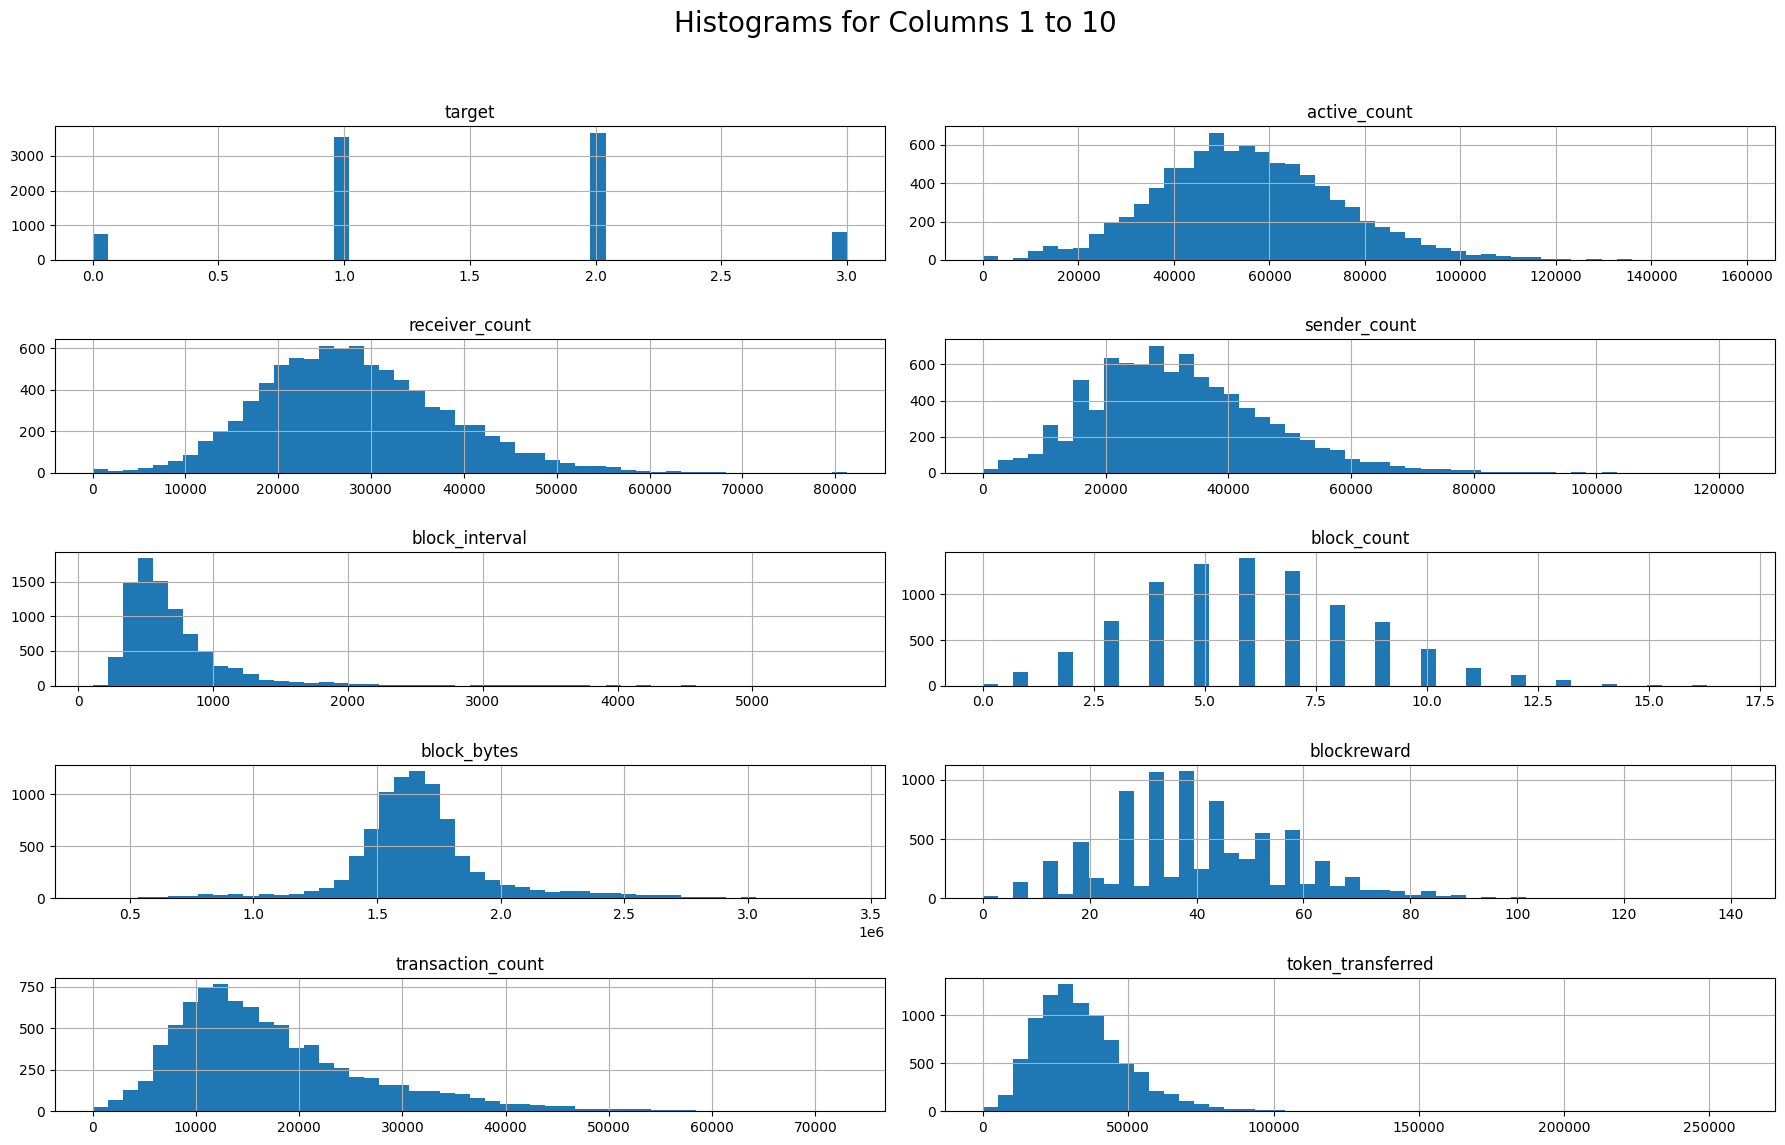

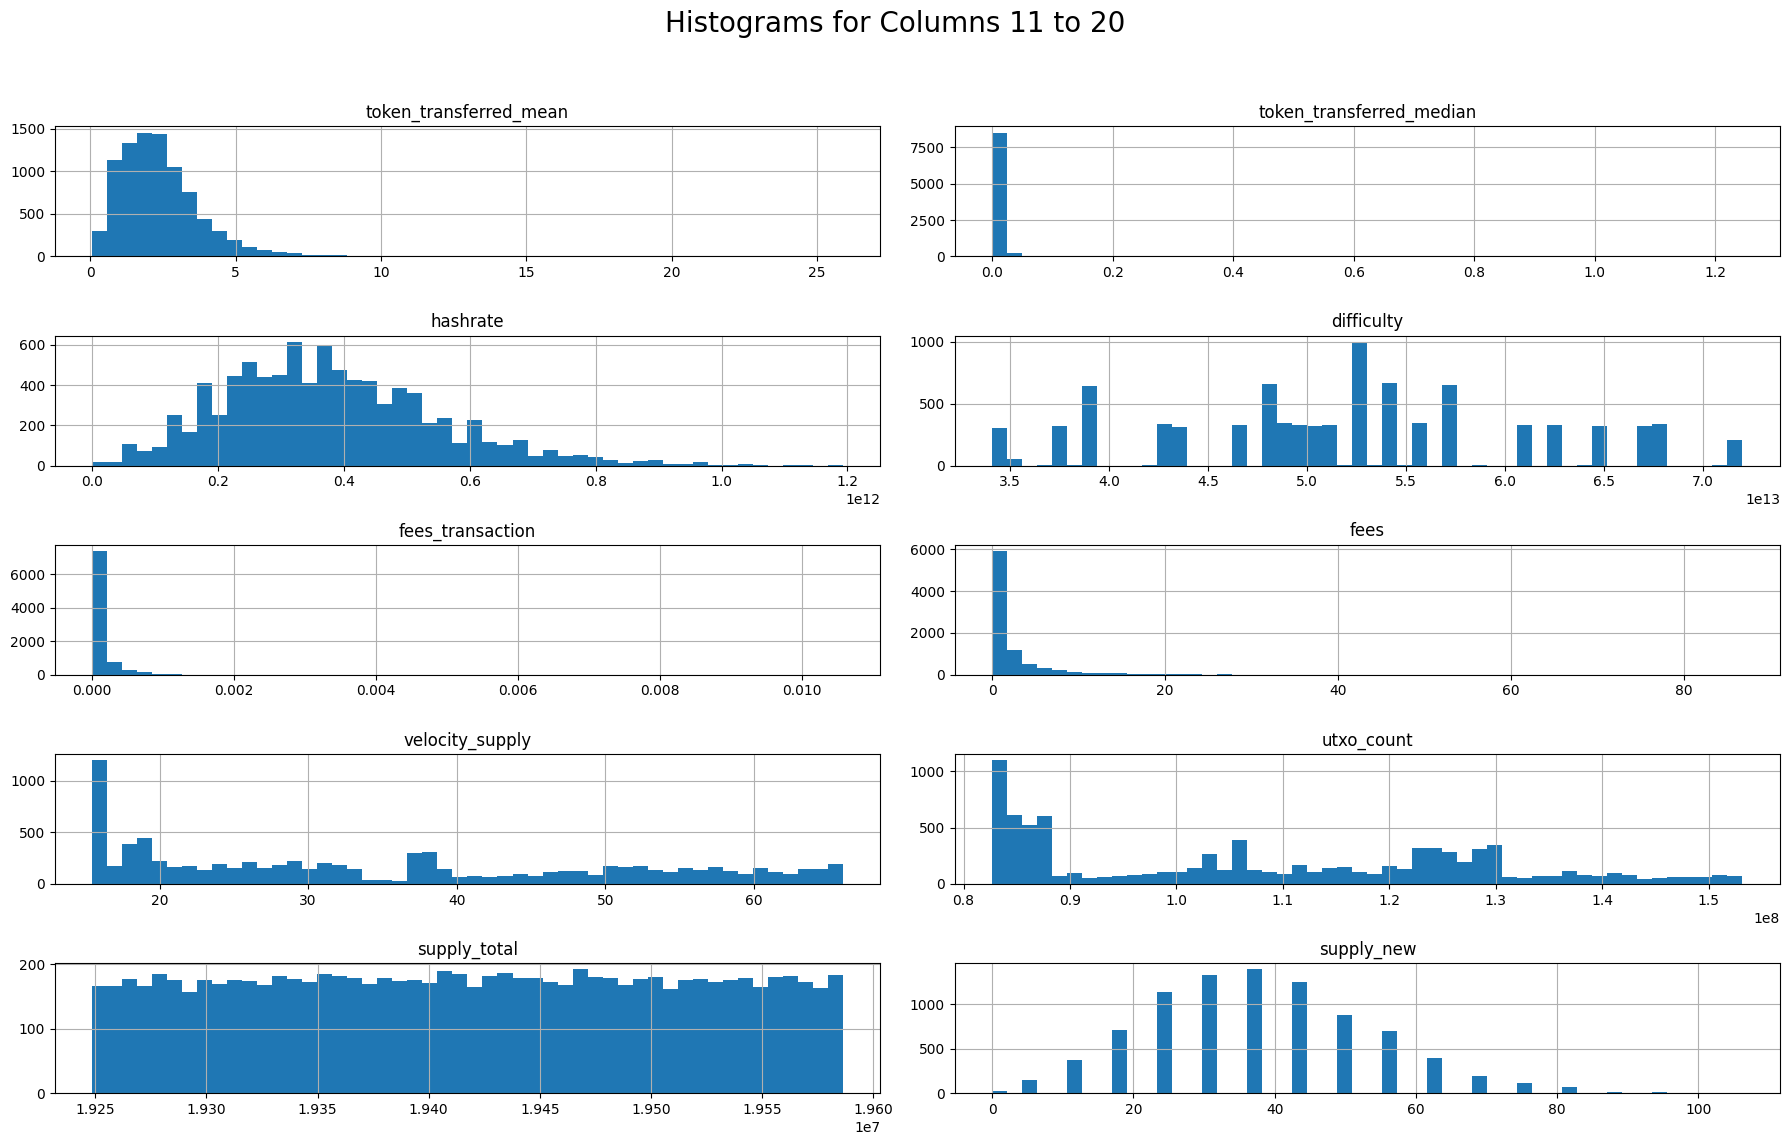

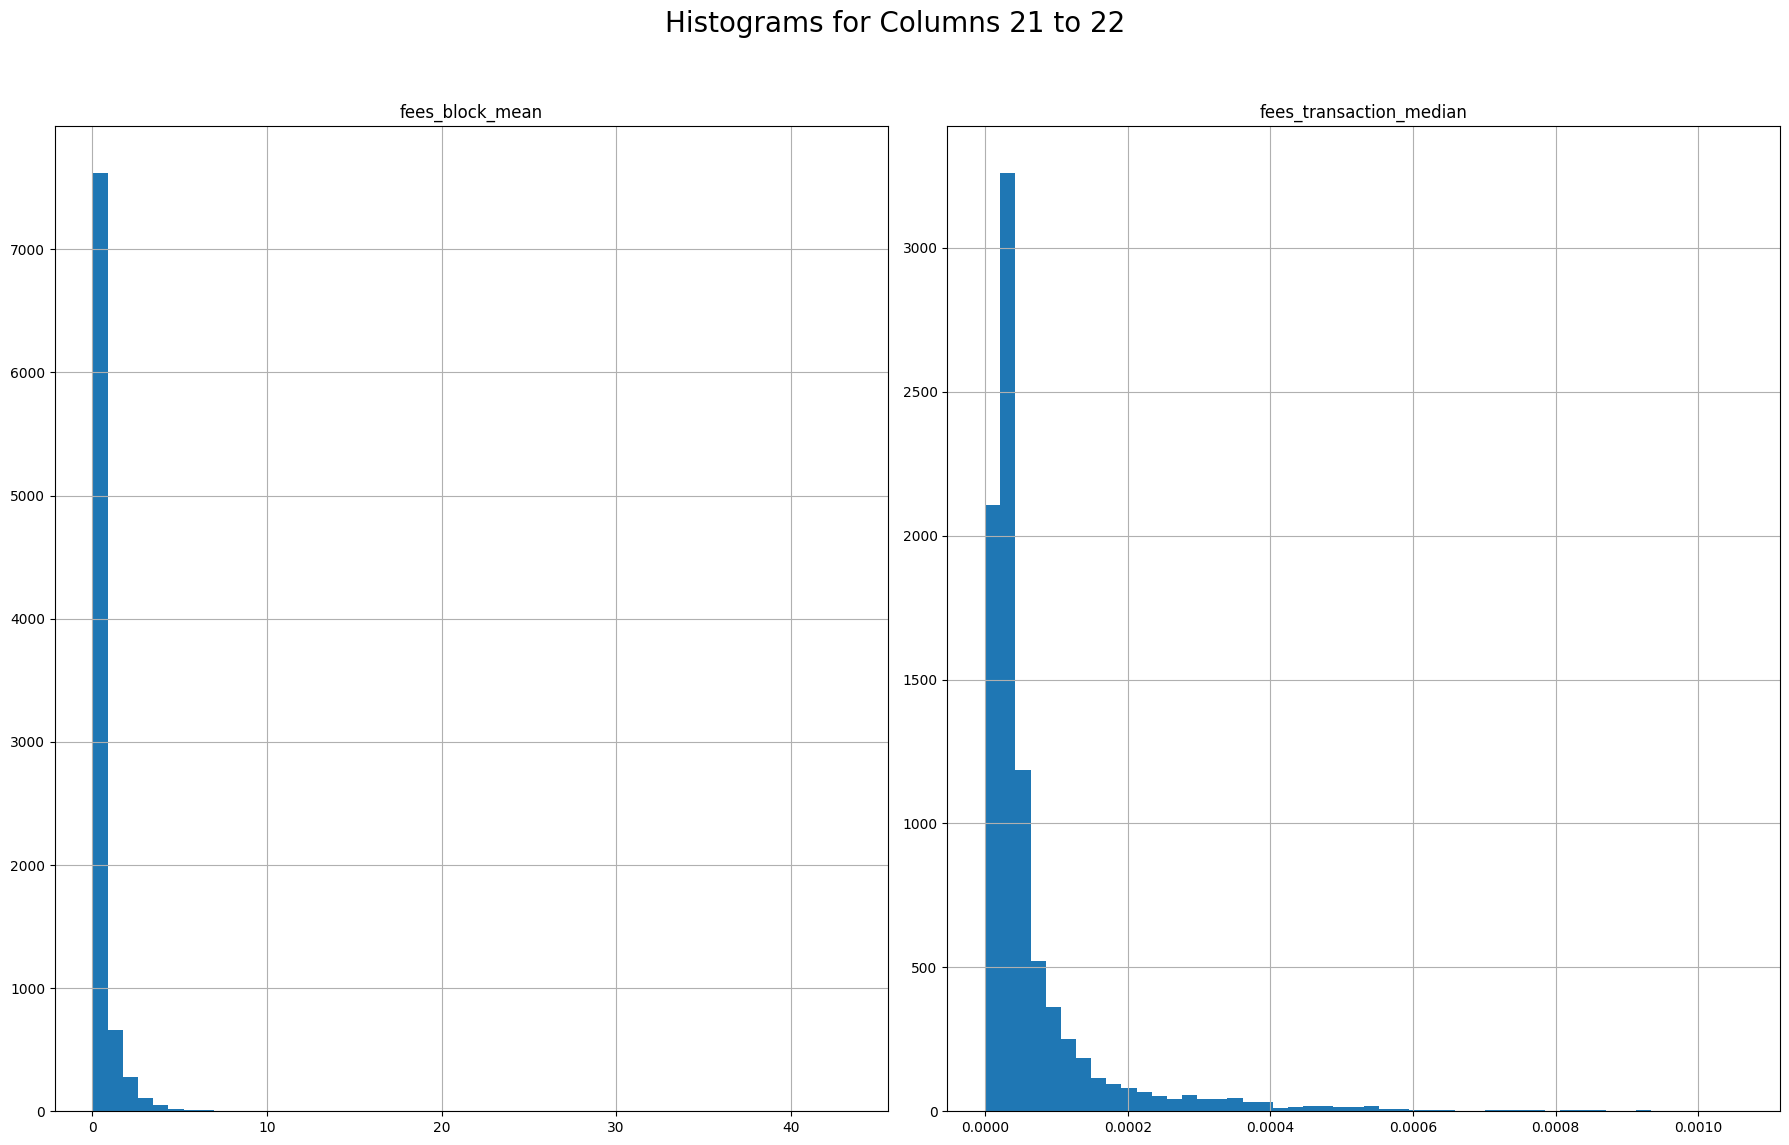

In [12]:
# eda_df_train_filtered 데이터 복사본 사용
eda_df_train_filtered = eda_df_train.copy()

# 총 열 수
total_columns = eda_df_train_filtered.columns

colors = plt.cm.get_cmap('tab20', len(columns_to_plot))

# 10개씩 나누어 시각화
for i in range(0, len(total_columns), 10):
    # i부터 i+10까지의 열 선택
    sample_columns = total_columns[i:i + 10]

    # 선택한 열에 대해 히스토그램 생성
    fig, axes = plt.subplots(nrows=len(sample_columns)//2 + len(sample_columns)%2, ncols=2, figsize=(18, 12))
    fig.suptitle(f'Histograms for Columns {i+1} to {i+len(sample_columns)}', fontsize=20)

    for idx, col in enumerate(sample_columns):
        ax = axes.flatten()[idx]
        eda_df_train_filtered[col].hist(bins=50, ax=ax)
        ax.set_title(col, fontsize=12)
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### 히스토그램 결과
- 전반적으로 우측으로 긴 꼬리를 가지는 분포의 형태를 가지고 있습니다.
- token_transferred_median, fees_transaction, fees, fees_block_mean, fees_block_median의 경우 0을 가지는 값이 지나치게 많은 경향을 보입니다.
- supply_new와 hashrate, active_count, receiver_count, sender_count의 경우 좌측으로 치우친 정규분포의 형태를 보입니다.

## 변수별 타겟값

In [13]:
aggregation_methods = ['mean', 'median', 'min', 'max']
bar_dfs = {}

for method in aggregation_methods:
    bar_dfs[method] = eda_df.groupby("target").agg({
        "active_count" : method,
        "receiver_count" : method,
        "sender_count" : method,
        'block_interval' : method,
        'block_count' : method,
        'block_bytes' : method,
        'blockreward' : method,
        'transaction_count' : method,
        'token_transferred' : method,
        'token_transferred_mean' : method,
        'token_transferred_median' : method,
        'hashrate' : method,
        'difficulty' : method,
        'fees_transaction' : method,
        'fees' : method,
        'velocity_supply' : method,
        'utxo_count' : method,
        'supply_total' : method,
        'supply_new' : method,
        'fees_block_mean' : method,
        'fees_transaction_median' : method,
    }).reset_index()

In [14]:
bar_dfs['mean']

target  active_count  receiver_count  sender_count  block_interval  \
0     0.0  56629.243243    29484.751351  32274.227027      721.145114   
1     1.0  55169.984481    27789.923533  32152.012133      696.779676   
2     2.0  55495.242441    28243.214928  32100.053119      690.233098   
3     3.0  56428.675776    29436.264596  32124.140373      701.695876   

   block_count   block_bytes  blockreward  transaction_count  \
0     6.027027  1.679341e+06    40.659331       17077.618919   
1     6.123025  1.678037e+06    40.917662       17556.318567   
2     6.127758  1.677566e+06    40.844442       17247.537456   
3     6.074534  1.683096e+06    40.843327       17384.886957   

   token_transferred  ...      hashrate    difficulty  fees_transaction  \
0       38329.139718  ...  3.725723e+11  5.182691e+13          0.000157   
1       33157.924073  ...  3.791698e+11  5.195136e+13          0.000144   
2       34067.001606  ...  3.794171e+11  5.203378e+13          0.000138   
3       36701.565729  ...  3.742107e+11  5.156398e+13          0.000157   

       fees  velocity_supply    utxo_count  supply_total  supply_new  \
0  2.990412        35.553803  1.067986e+08  1.941428e+07   37.668919   
1  2.648757        35.155068  1.083903e+08  1.941838e+07   38.268905   
2  2.545954        34.997218  1.087523e+08  1.941971e+07   38.298488   
3  2.877488        36.264021  1.060951e+08  1.941101e+07   37.965839   

   fees_block_mean  fees_transaction_median  
0         0.514955                 0.000076  
1         0.465463                 0.000067  
2         0.440674                 0.000066  
3         0.505788                 0.000077  

[4 rows x 22 columns]

<ipython-input-15-9064d9c3179a>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(columns_to_plot))


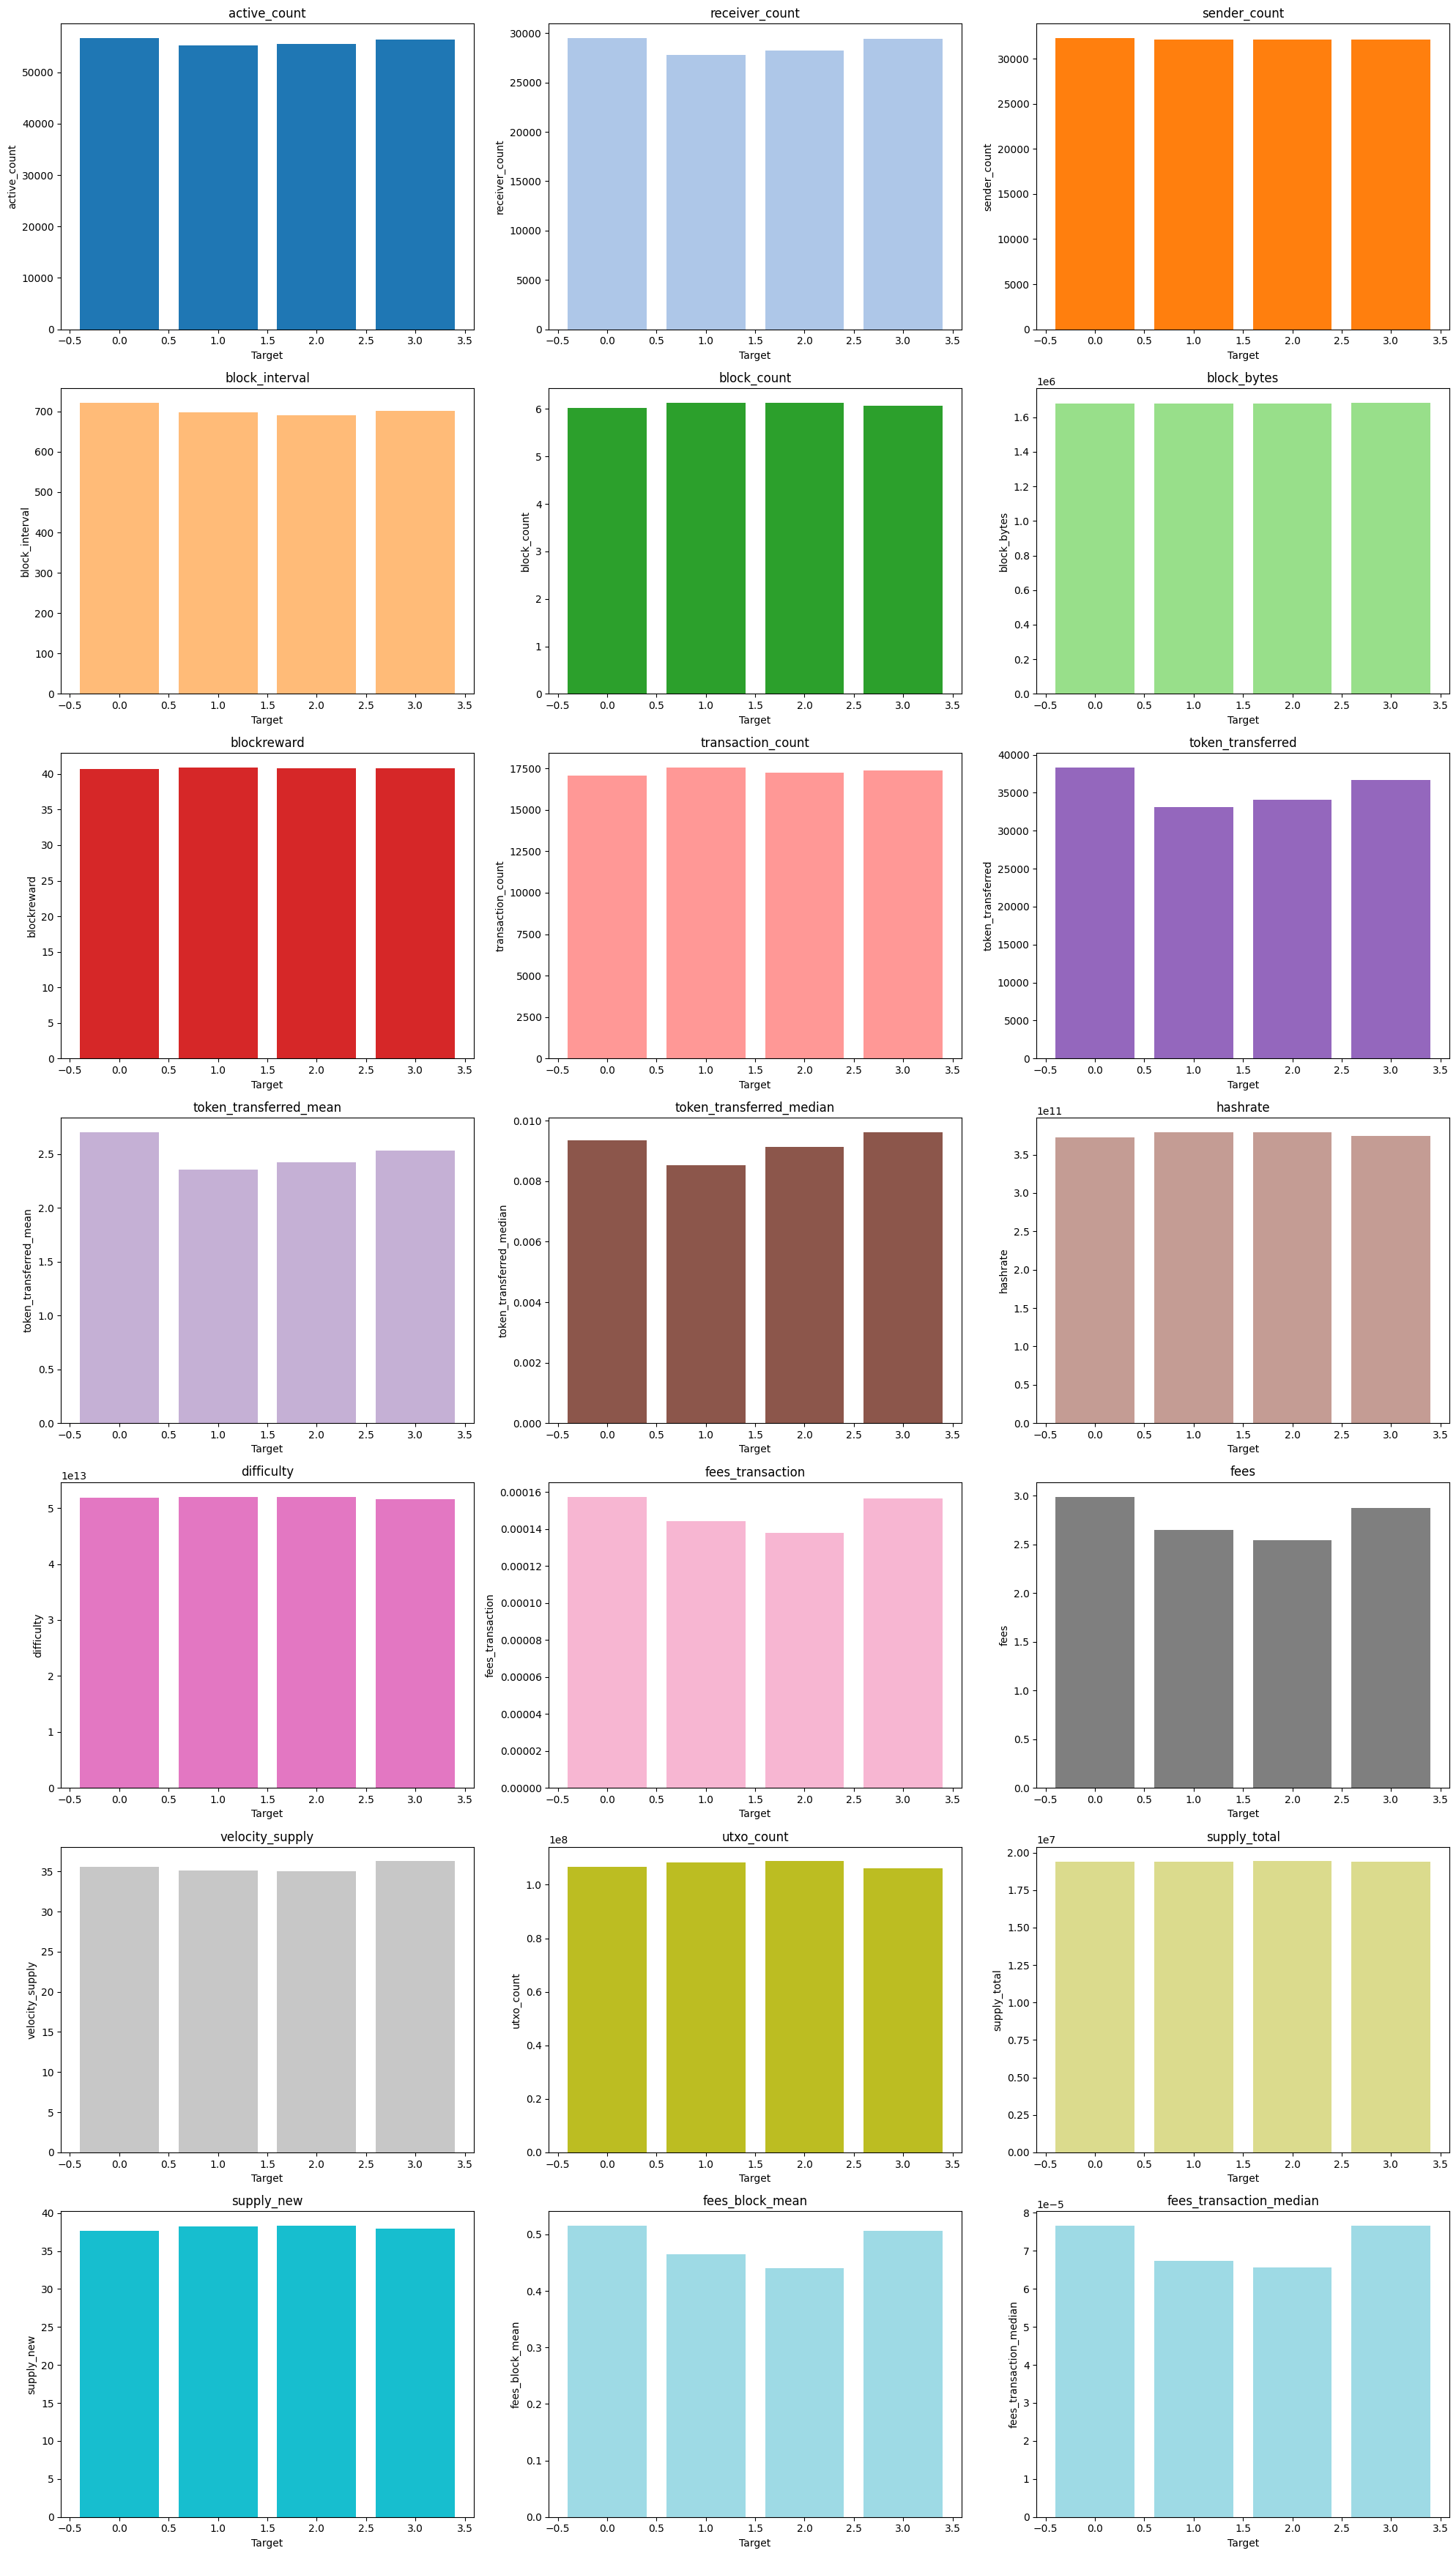

In [15]:
columns_to_plot = [
    "active_count", "receiver_count", "sender_count", 'block_interval', 'block_count',
    'block_bytes', 'blockreward', 'transaction_count', 'token_transferred', 'token_transferred_mean',
    'token_transferred_median', 'hashrate', 'difficulty', 'fees_transaction', 'fees',
    'velocity_supply', 'utxo_count', 'supply_total', 'supply_new', 'fees_block_mean', 'fees_transaction_median'
]

# 컬러맵을 이용해 다양한 색상 선택
colors = plt.cm.get_cmap('tab20', len(columns_to_plot))

# Plot의 행과 열 설정
num_columns = 3
num_rows = math.ceil(len(columns_to_plot) / num_columns)  # ceil로 반올림하여 row 계산

# 그래프 크기 설정
plt.figure(figsize=(20, 5 * num_rows))

# 각 변수에 대해 서브플롯 생성
for i, col in enumerate(columns_to_plot):
    plt.subplot(num_rows, num_columns, i + 1)  # 서브플롯 위치 설정
    plt.bar(bar_dfs['mean']['target'], bar_dfs['mean'][col], color=colors(i))  # 막대 그래프 생성
    plt.title(col)  # 각 그래프의 제목
    plt.xlabel("Target")
    plt.ylabel(col)

# 레이아웃 정리
plt.tight_layout()
plt.show()

- 큰 차이를 나타낸다고 보기는 어렵지만 대체로 0,3과 1,2가 비슷한 경향성을 나타낸다.

In [16]:
bar_dfs['median']

target  active_count  receiver_count  sender_count  block_interval  \
0     0.0       55561.5         28900.5       30545.0           604.0   
1     1.0       54163.0         27051.5       30603.0           599.0   
2     2.0       54262.0         27350.0       30577.0           595.0   
3     3.0       56129.0         28829.0       30840.0           580.4   

   block_count   block_bytes  blockreward  transaction_count  \
0          6.0  1.636949e+06    38.541684            14865.0   
1          6.0  1.657122e+06    38.762990            15170.0   
2          6.0  1.651432e+06    38.922334            15003.0   
3          6.0  1.647714e+06    39.016510            15797.0   

   token_transferred  ...      hashrate    difficulty  fees_transaction  \
0       35472.121903  ...  3.587773e+11  5.123434e+13          0.000087   
1       30700.548480  ...  3.625397e+11  5.232831e+13          0.000082   
2       31186.422023  ...  3.640622e+11  5.232831e+13          0.000082   
3       34205.402102  ...  3.625397e+11  5.064621e+13          0.000087   

       fees  velocity_supply   utxo_count  supply_total  supply_new  \
0  1.207453        32.074583  106142040.0  1.941546e+07        37.5   
1  1.131462        31.304770  106516837.0  1.941989e+07        37.5   
2  1.112947        30.719525  107251911.0  1.942443e+07        37.5   
3  1.181312        32.538308  105810940.0  1.941246e+07        37.5   

   fees_block_mean  fees_transaction_median  
0         0.221096                 0.000037  
1         0.205065                 0.000034  
2         0.205316                 0.000034  
3         0.224472                 0.000037  

[4 rows x 22 columns]

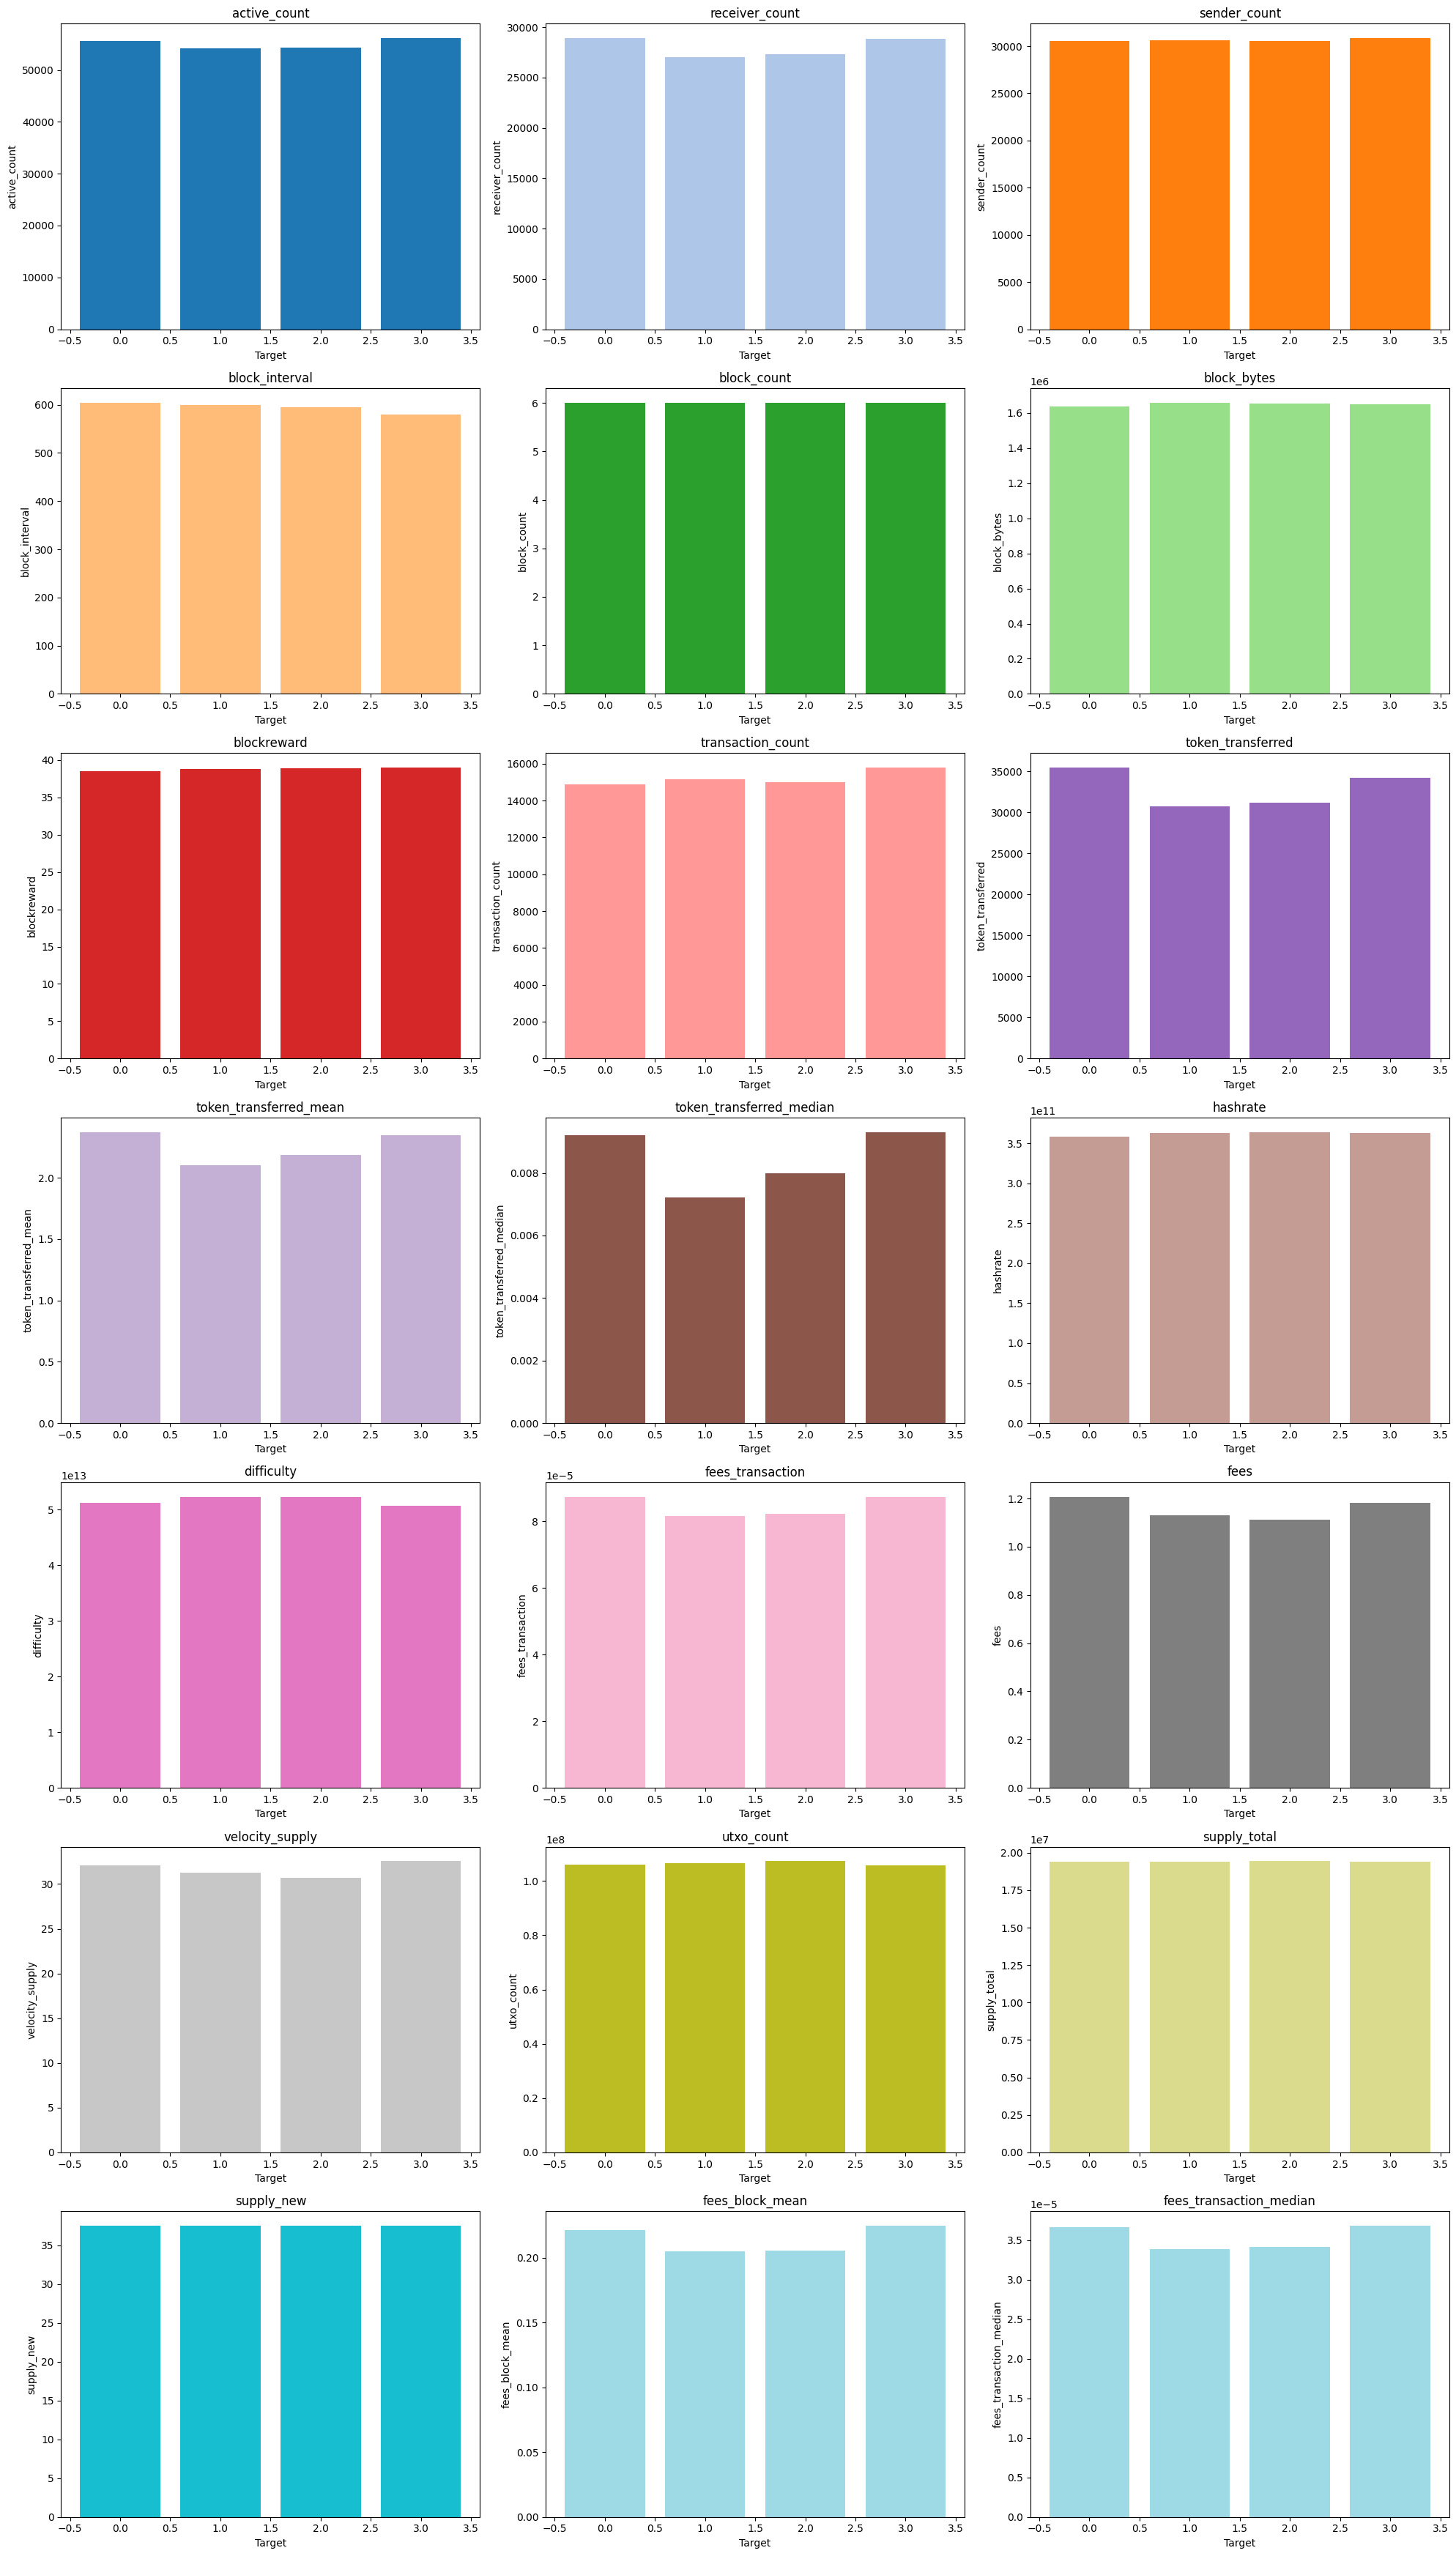

In [17]:
# 그래프 크기 설정
plt.figure(figsize=(20, 5 * num_rows))

# 각 변수에 대해 서브플롯 생성
for i, col in enumerate(columns_to_plot):
    plt.subplot(num_rows, num_columns, i + 1)  # 서브플롯 위치 설정
    plt.bar(bar_dfs['median']['target'], bar_dfs['median'][col], color=colors(i))  # 막대 그래프 생성
    plt.title(col)  # 각 그래프의 제목
    plt.xlabel("Target")
    plt.ylabel(col)

# 레이아웃 정리
plt.tight_layout()
plt.show()

- 큰 차이를 나타낸다고 보기는 어렵지만 대체로 0,3과 1,2가 비슷한 경향성을 나타낸다.
- 대체로 평균보다 중앙값이 낮은 모습을 보인다. (difficulty, supply_total 제외 전 변수)
- 네트워크 데이터는 대부분 우측으로 긴 꼬리를 가진다.

In [18]:
bar_dfs['min']

target  active_count  receiver_count  sender_count  block_interval  \
0     0.0             0               0             0      241.857143   
1     1.0             0               0             0      177.333333   
2     2.0             0               0             0      106.000000   
3     3.0             0               0             0      212.000000   

   block_count    block_bytes  blockreward  transaction_count  \
0          0.0  549585.900000          0.0                0.0   
1          0.0  349018.214286          0.0                0.0   
2          0.0  385245.538462          0.0                0.0   
3          0.0  651973.750000          0.0                0.0   

   token_transferred  ...  hashrate    difficulty  fees_transaction  fees  \
0                0.0  ...       0.0  3.409357e+13          0.000014   0.0   
1                0.0  ...       0.0  3.409357e+13          0.000013   0.0   
2                0.0  ...       0.0  3.409357e+13          0.000015   0.0   
3                0.0  ...       0.0  3.409357e+13          0.000012   0.0   

   velocity_supply  utxo_count  supply_total  supply_new  fees_block_mean  \
0        15.474537  82705388.0  1.925226e+07         0.0         0.033933   
1        15.474395  82689520.0  1.924874e+07         0.0         0.017771   
2        15.472814  82693100.0  1.924871e+07         0.0         0.017193   
3        15.475473  82712124.0  1.925166e+07         0.0         0.041330   

   fees_transaction_median  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  

[4 rows x 22 columns]

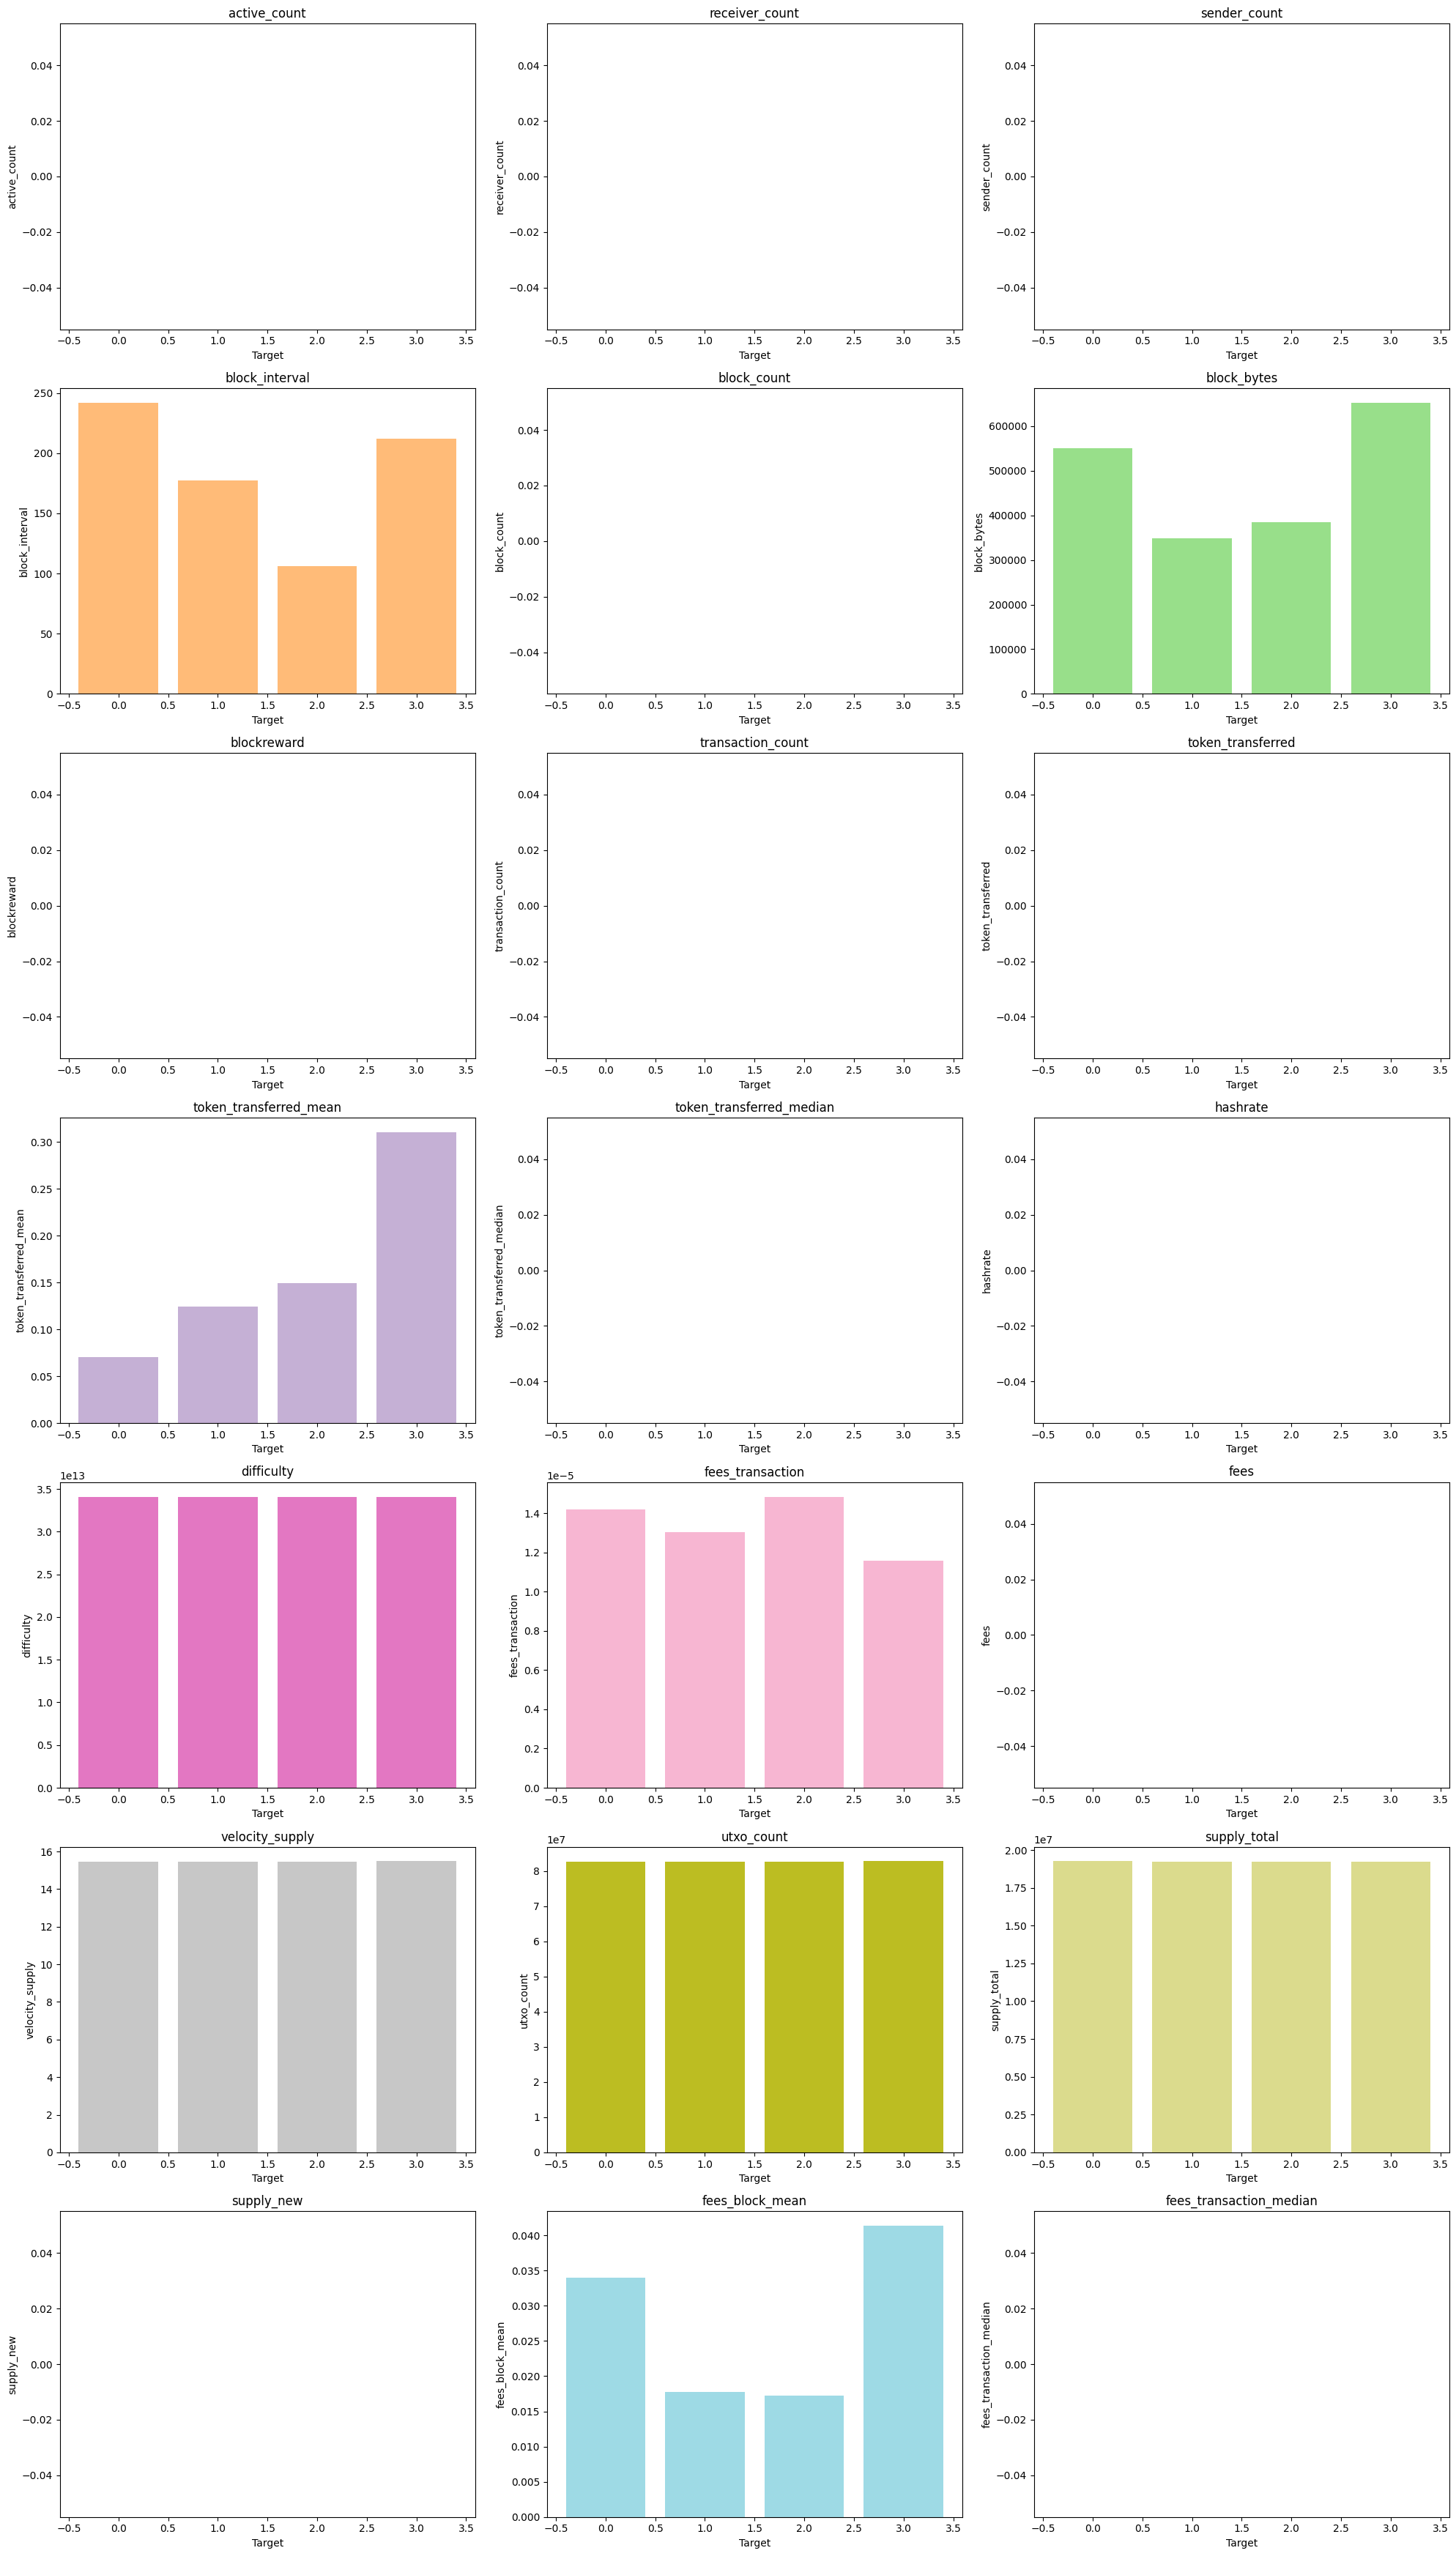

In [19]:
# 그래프 크기 설정
plt.figure(figsize=(20, 5 * num_rows))

# 각 변수에 대해 서브플롯 생성
for i, col in enumerate(columns_to_plot):
    plt.subplot(num_rows, num_columns, i + 1)  # 서브플롯 위치 설정
    plt.bar(bar_dfs['min']['target'], bar_dfs['min'][col], color=colors(i))  # 막대 그래프 생성
    plt.title(col)  # 각 그래프의 제목
    plt.xlabel("Target")
    plt.ylabel(col)

# 레이아웃 정리
plt.tight_layout()
plt.show()

- fees_block_mean은 타겟값이 증가할수록 최소값이 증가한다고도 볼 수 있으나 1,2는 큰 차이가 없다.
- token_transferred_mean은 타겟값이 증가할수록 최소값이 증가한다.
- block_interval, block_bytes은 타겟값이 0,3일때와 1,2일때가 유의미하게 차이난다.

In [20]:
bar_dfs['max']

target  active_count  receiver_count  sender_count  block_interval  \
0     0.0        121220           69521         93740          5360.0   
1     1.0        143067           81258        102706          5701.0   
2     2.0        157981           81245        123005          4247.0   
3     3.0        142048           73604        102860          4497.0   

   block_count   block_bytes  blockreward  transaction_count  \
0         15.0  2.993586e+06   104.773124            57297.0   
1         17.0  3.401656e+06   141.211238            69512.0   
2         16.0  3.217845e+06   112.088746            73049.0   
3         16.0  3.061614e+06   100.857698            59610.0   

   token_transferred  ...      hashrate    difficulty  fees_transaction  \
0      254874.623048  ...  9.635889e+11  7.200615e+13          0.001638   
1      160360.588447  ...  1.053998e+12  7.200615e+13          0.010572   
2      259621.252610  ...  1.192349e+12  7.200615e+13          0.001748   
3      102304.946695  ...  1.116787e+12  7.200615e+13          0.001654   

        fees  velocity_supply   utxo_count  supply_total  supply_new  \
0  48.523124        65.568836  153138595.0  1.958609e+07       93.75   
1  86.750001        65.977755  153128637.0  1.958607e+07      106.25   
2  44.666099        65.978971  153172052.0  1.958613e+07      100.00   
3  42.813523        65.655950  152811512.0  1.958558e+07      100.00   

   fees_block_mean  fees_transaction_median  
0         6.662988                 0.001061  
1        43.375001                 0.000933  
2         7.169291                 0.001021  
3         6.116218                 0.000994  

[4 rows x 22 columns]

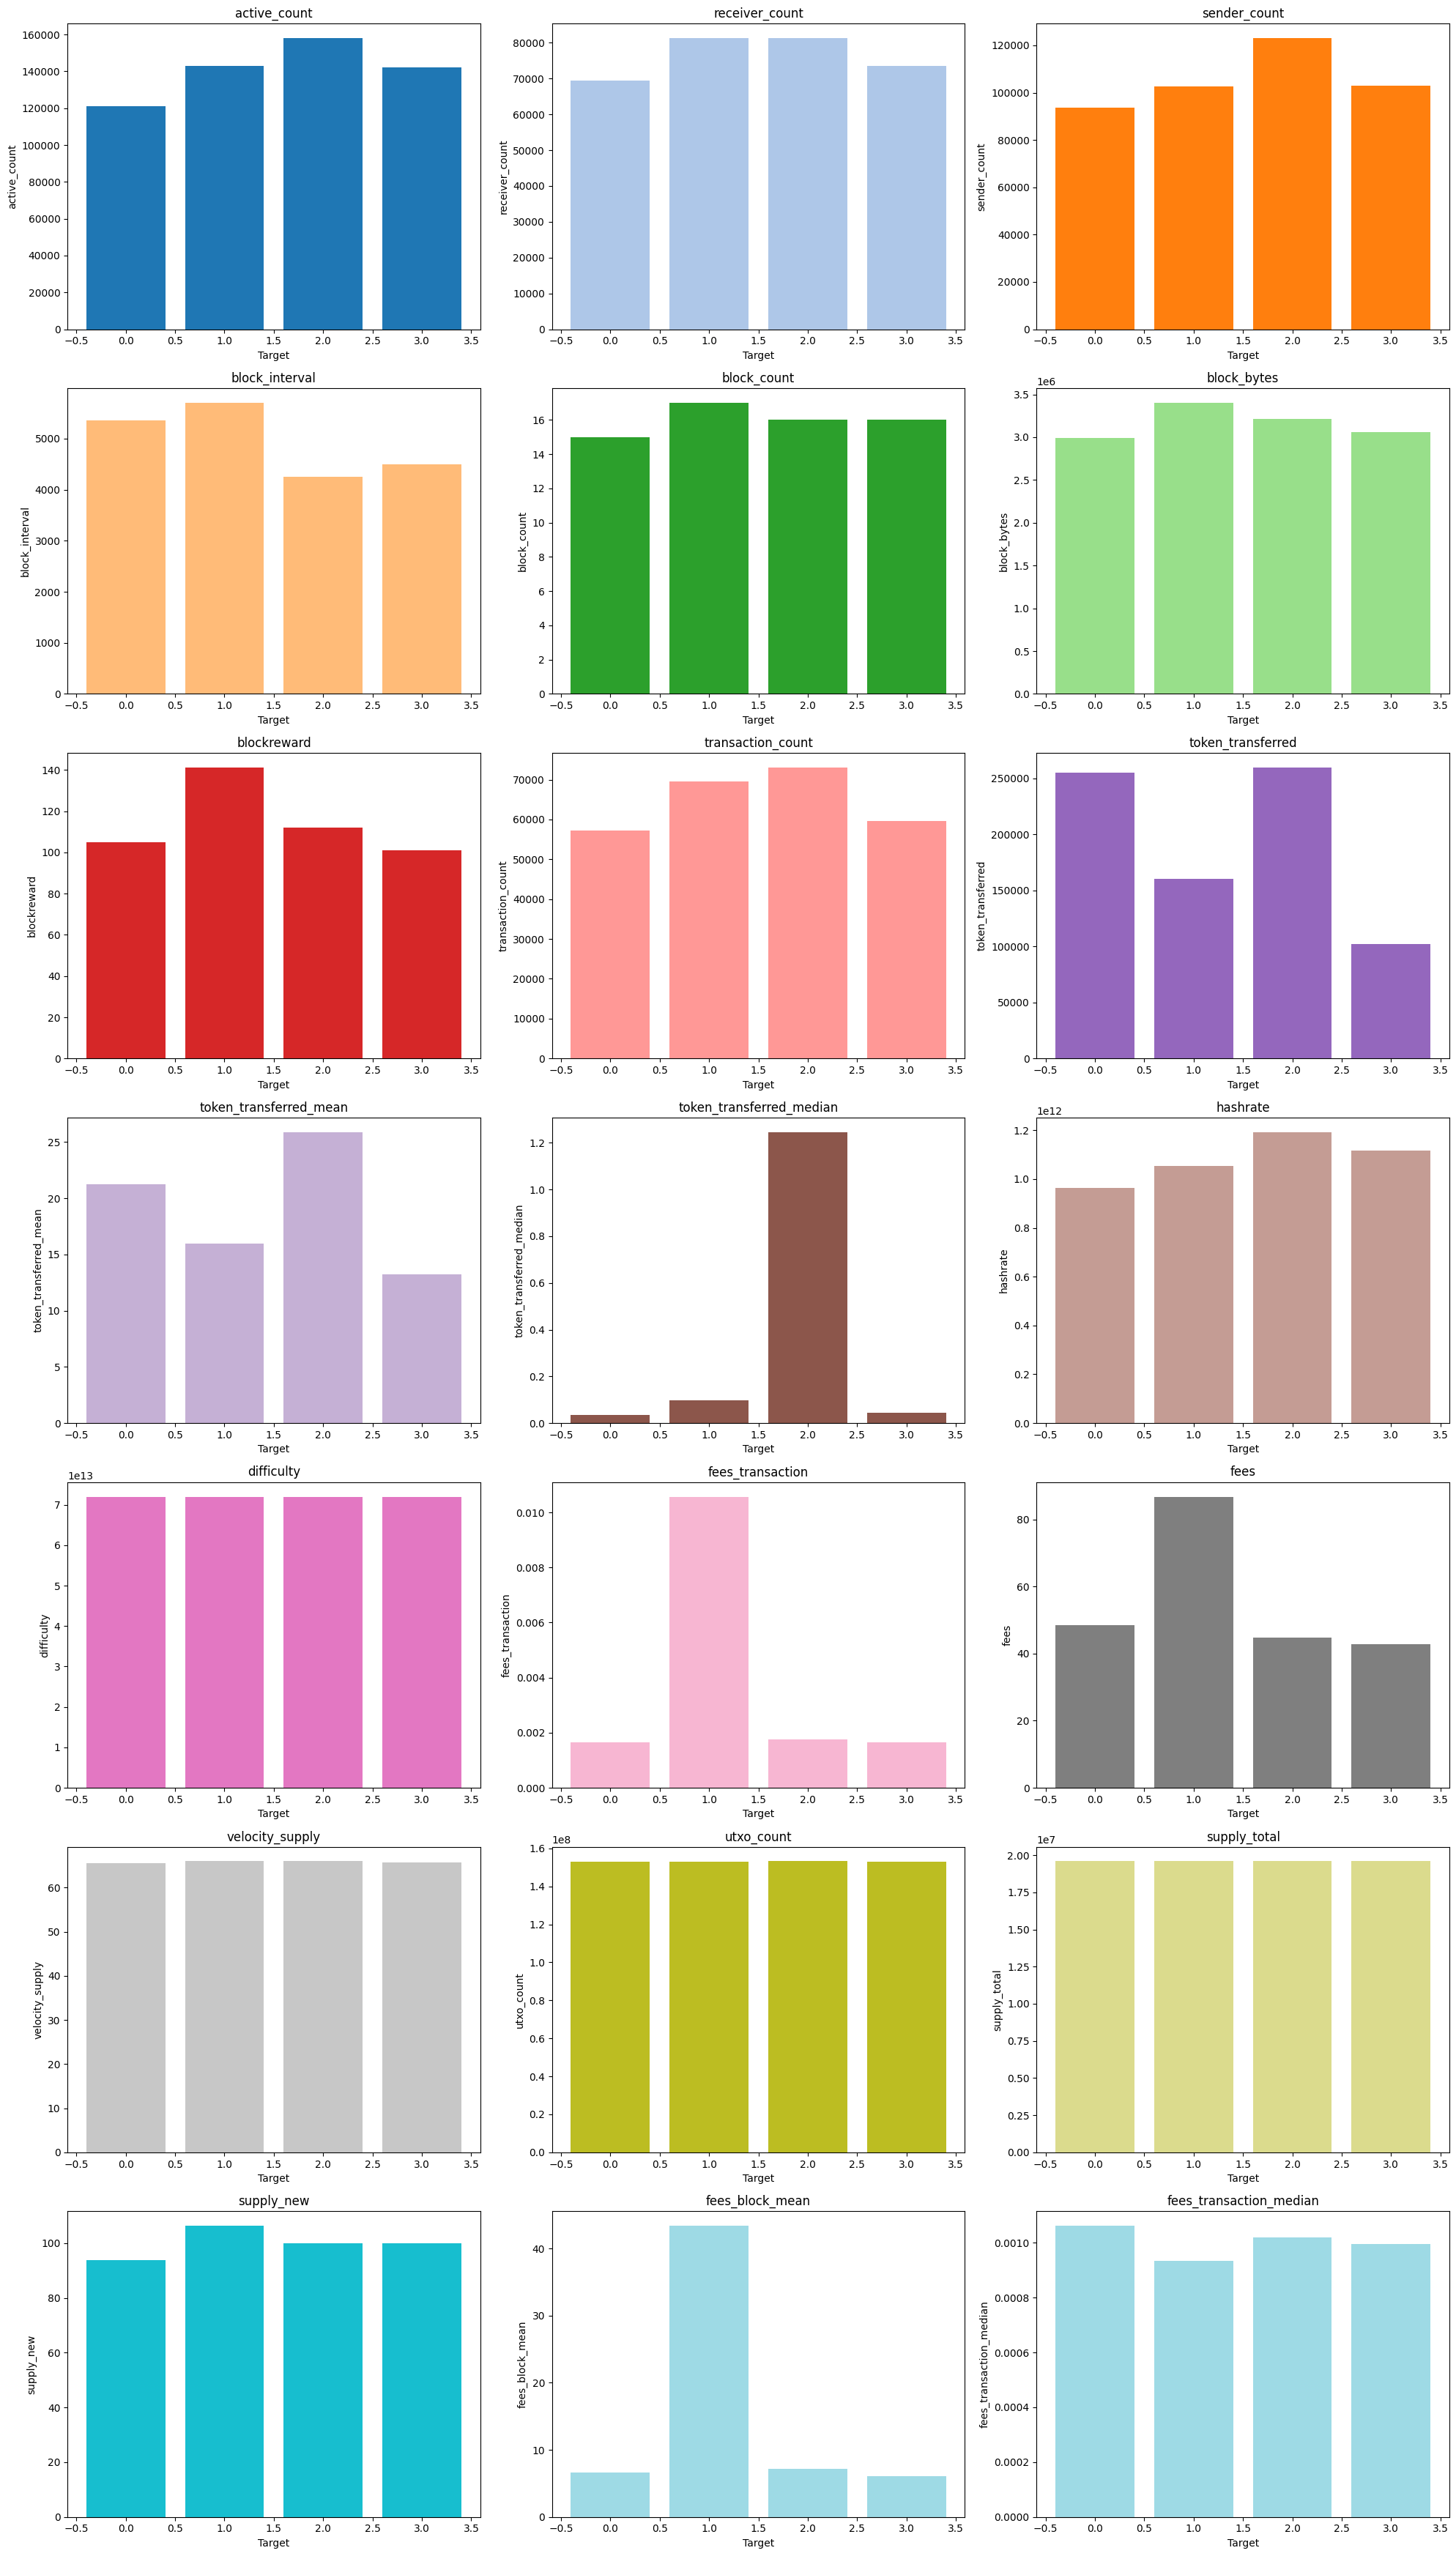

In [21]:
# 그래프 크기 설정
plt.figure(figsize=(20, 5 * num_rows))

# 각 변수에 대해 서브플롯 생성
for i, col in enumerate(columns_to_plot):
    plt.subplot(num_rows, num_columns, i + 1)  # 서브플롯 위치 설정
    plt.bar(bar_dfs['max']['target'], bar_dfs['max'][col], color=colors(i))  # 막대 그래프 생성
    plt.title(col)  # 각 그래프의 제목
    plt.xlabel("Target")
    plt.ylabel(col)

# 레이아웃 정리
plt.tight_layout()
plt.show()

- block_interval은 타겟값이 0,1일 때와 2 ,3일 때의 최댓값의 차이가 조금 있다.
- blockreward, fees_transaction, fees, fees_block_mean은 타겟값이 1일때만 유독 높은 최댓값을 가진다.
- token_transferred_median은 타겟값이 2일 때만 유독 높은 최댓값을 가진다.
- token_transferred, token_transferred_mean은 타겟값이 0,2일때가 비슷하고 1,3일때가 비슷하다.

## Target과의 상관관계 분석

### Feature Importance

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4655
[LightGBM] [Info] Number of data points in the train set: 8760, number of used features: 21
[LightGBM] [Info] Start training from score -2.471301
[LightGBM] [Info] Start training from score -0.904940
[LightGBM] [Info] Start training from score -0.869732
[LightGBM] [Info] Start training from score -2.387109


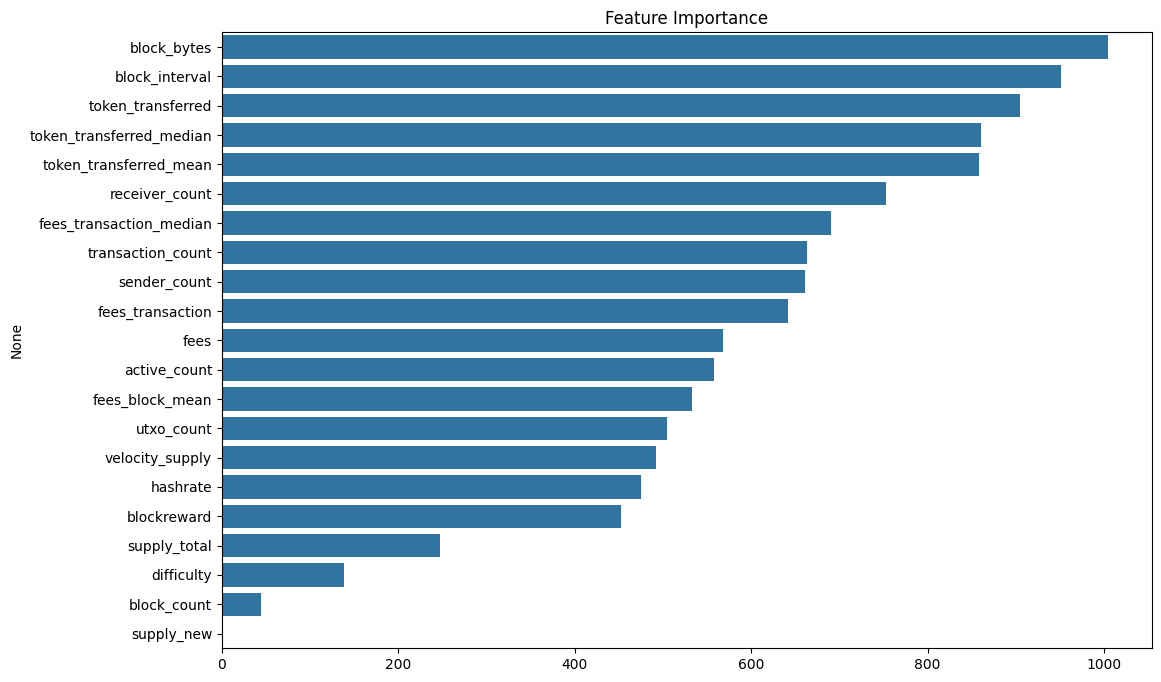

In [24]:
# LightGBM 모델 학습
lgbm = LGBMClassifier()
X = eda_df_train_filtered.drop(columns=['target'])
y = eda_df_train_filtered['target']

lgbm.fit(X, y)

# 피처 중요도 시각화
feature_importance = pd.Series(lgbm.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance")
plt.show()

- block_bytes, block_interval, token_transferred는 모델에서 가장 중요한 feature로 평가됩니다.
- token_transferred_median, token_transferred_mean도 중요하게 나타나, 거래당 전송된 코인의 평균과 중앙값이 target에 영향을 끼치는 것을 알 수 있습니다.
- block_count, difficulty는 비교적 중요도가 낮아, target을 예측하는 데 상대적으로 덜 중요한 역할을 합니다.

### Kendall Tau Correlation Heatmap

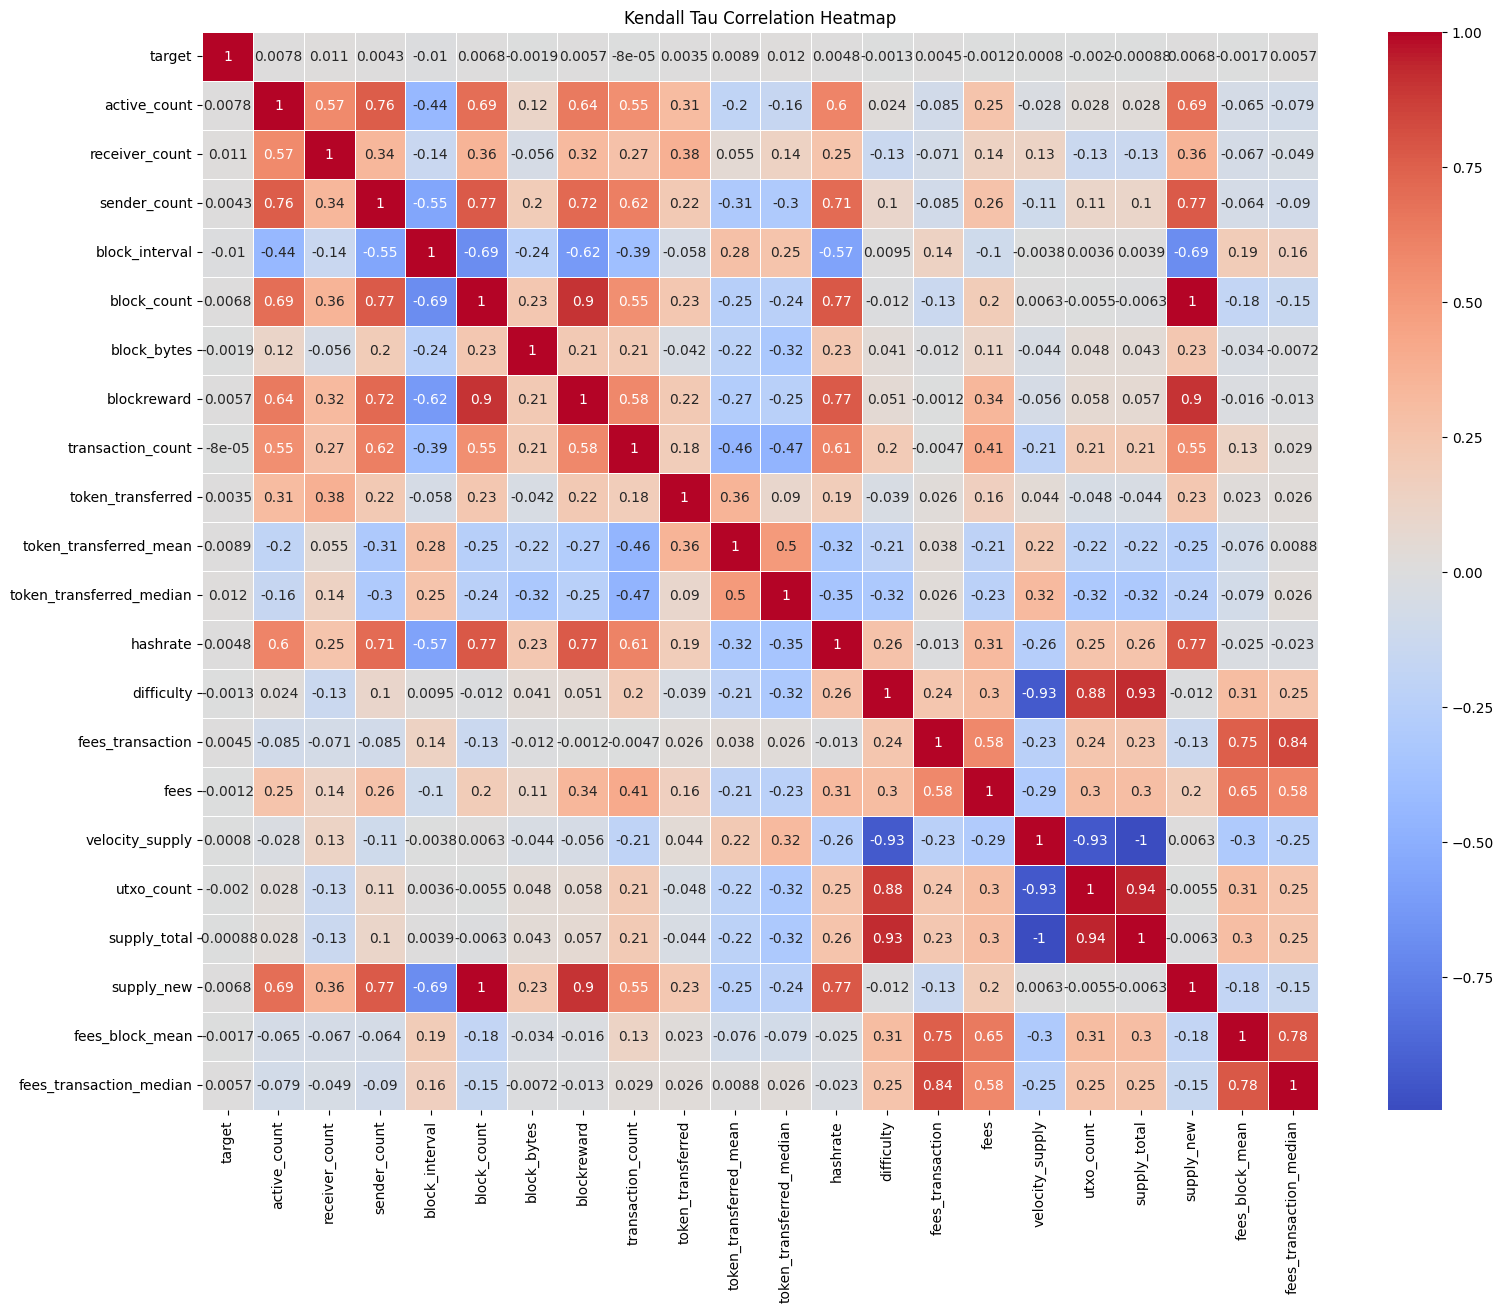

In [25]:
# Kendall Tau Correlation 계산
kendall_corr = eda_df_train_filtered.corr(method='kendall')

# 시각화
plt.figure(figsize=(18, 14))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Kendall Tau Correlation Heatmap")
plt.show()

- supply_total, velocity_supply는 완벽한 음의 상관관계를 가집니다. 두 변수가 본질적으로 같은 정보를 제공함을 의미하지만, 이를 제거하기보다는 Feature Engineering을 통해 유의미한 결과를 만들 수 있습니다.
- 모든 변수와 target 간의 상관관계가 크지 않습니다. 직접적인 선형 관계가 없을 수 있음을 의미합니다.
- target을 예측하기 위해서는 비선형 관계를 포착할 수 있는 더 복잡한 모델이 필요할 것입니다.

## 이상치 확인

### 변수별 이상치 확인

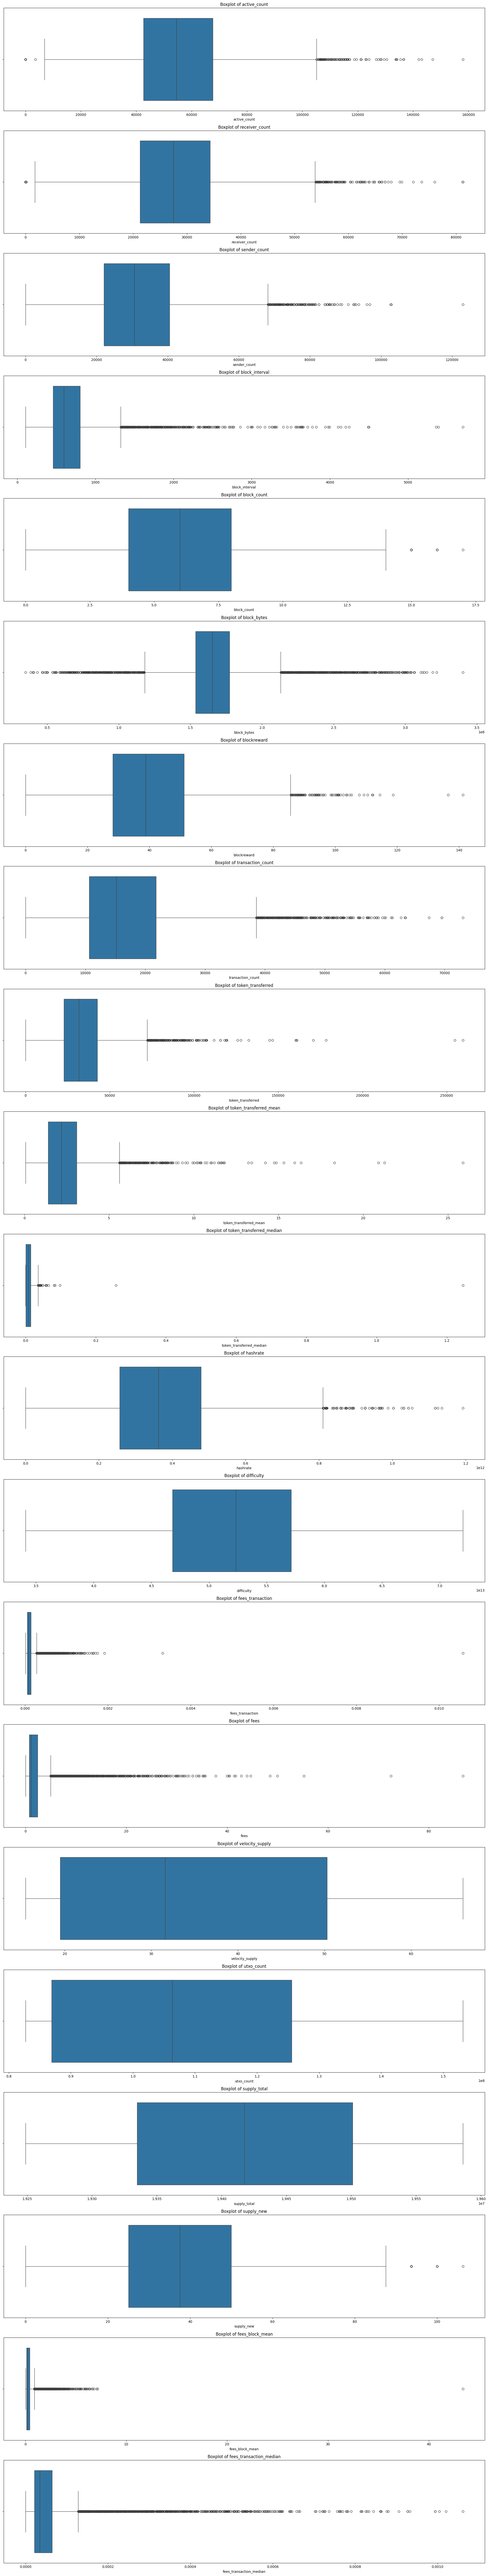

In [26]:
# 변수 리스트 (수치형 변수만 선택)
numeric_columns = eda_df_train_filtered.drop(columns='target').select_dtypes(include=['float64', 'int64']).columns

# 각 변수에 대해 박스플롯 그리기
plt.figure(figsize=(20, len(numeric_columns) * 5))

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 1, i)
    sns.boxplot(x=eda_df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

### 변수별 타겟별 이상치 확인

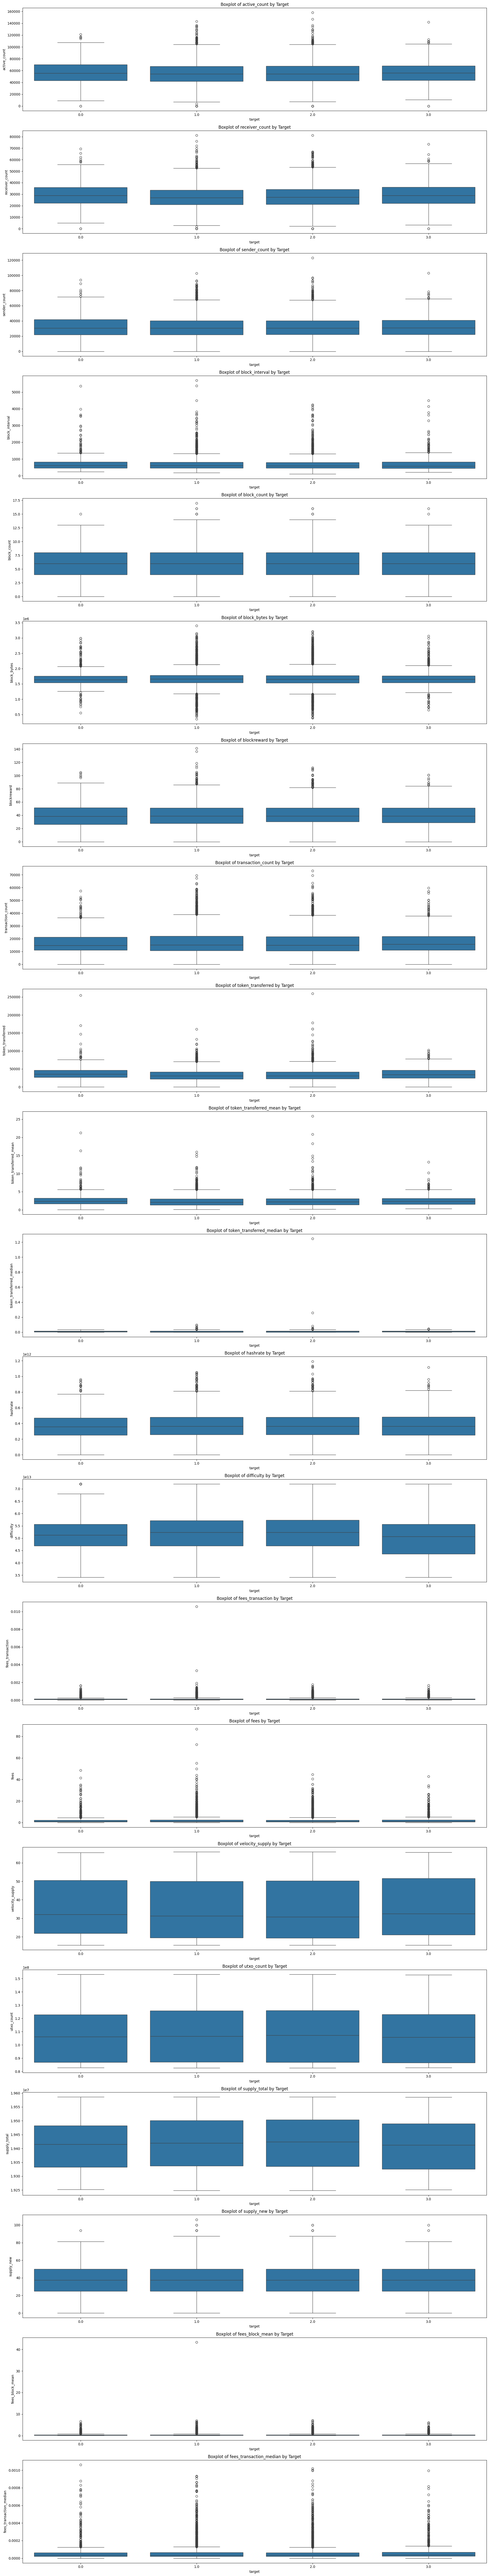

In [27]:
# 각 변수에 대해 타겟별로 박스플롯 그리기
plt.figure(figsize=(20, len(numeric_columns) * 5))

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 1, i)
    sns.boxplot(x=eda_df['target'], y=eda_df[column])
    plt.title(f'Boxplot of {column} by Target')

plt.tight_layout()
plt.show()

- 전반적으로 우측 꼬리의 분포를 가지고 있기에 우측에 이상치가 많이 분포한 것을 확인할 수 있습니다.
- 대부분의 변수가 많은 이상치를 보유하고 있습니다.
- block_bytes의 경우 좌우로 많은 이상치를 보유한 것을 확인할 수 있습니다.
- 각 변수별로도 변수별 타겟별로도 비슷한 양상을 보이는 것을 확인할 수 있습니다.
- target을 예측할 때 이상치의 처리가 영향을 줄 수도 있을 것입니다.

## 시계열 분석

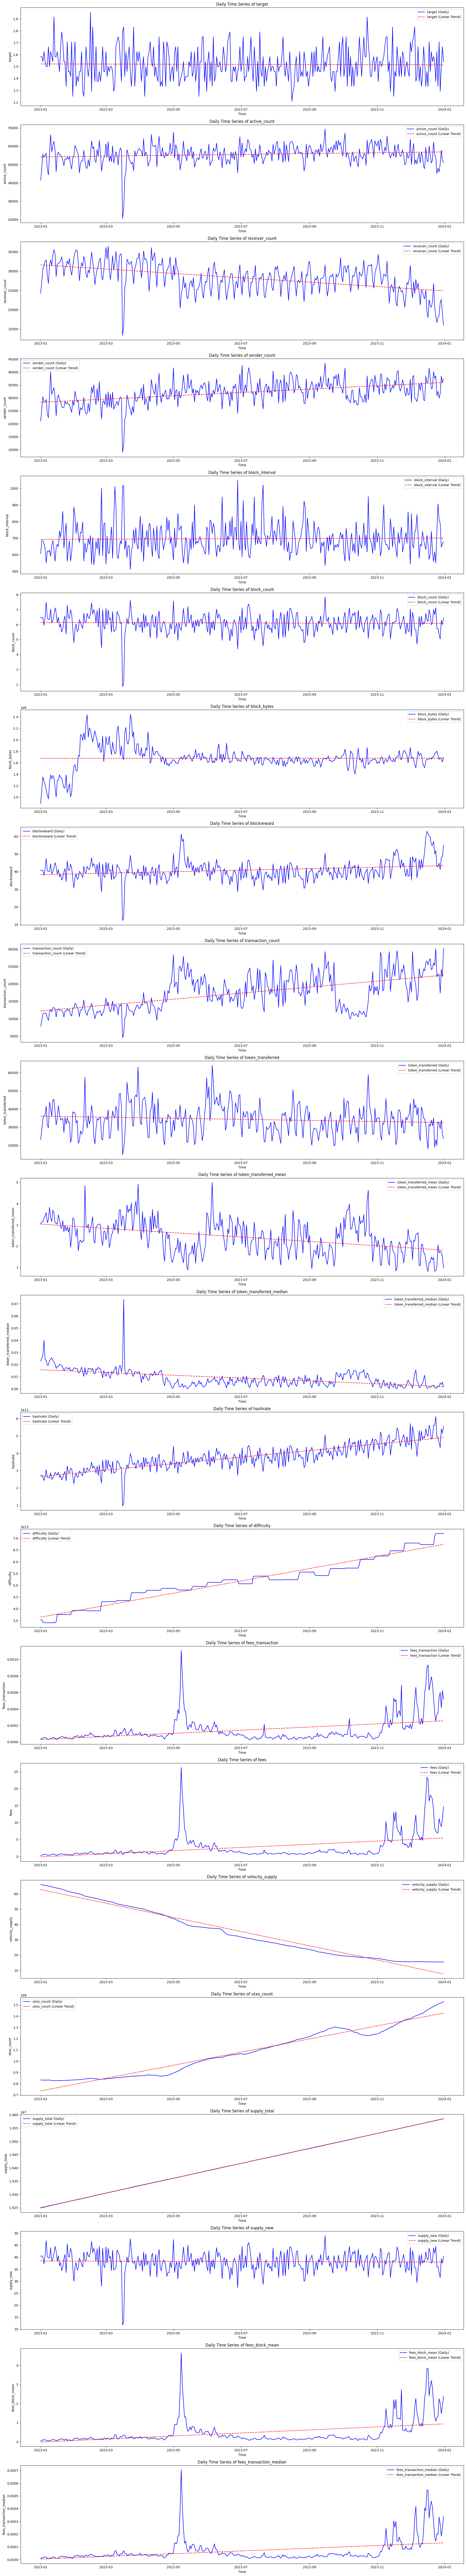

In [28]:
eda_df_train_time = eda_df.copy()

# 'ID' 컬럼을 datetime 형식으로 변환
eda_df_train_time['ID'] = pd.to_datetime(eda_df_train_time['ID'])

# 'ID' 컬럼을 인덱스로 설정 (리샘플링에 필요)
eda_df_train_time.set_index('ID', inplace=True)

numeric_columns = eda_df_train_time.select_dtypes(include=['float64', 'int64']).columns

# 하루(Daily) 단위 리샘플링
plt.figure(figsize=(20, len(numeric_columns) * 5))

window_size = 31

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 1, i)

    # 하루 단위로 데이터 리샘플링 (평균 사용)
    resampled_data = eda_df_train_time[column].resample('D').mean()

    # 원래 시계열 데이터 플롯
    plt.plot(resampled_data, label=f'{column} (Daily)', color='blue')

    # 선형 회귀를 위한 데이터 준비
    x = np.arange(len(resampled_data)).reshape(-1, 1)  # 날짜를 숫자로 변환 (1차원 배열)
    y = resampled_data.values.reshape(-1, 1)  # 리샘플된 데이터를 y로 설정

    # 선형 회귀 모델 학습
    model = LinearRegression()
    model.fit(x, y)
    trend_line = model.predict(x)

    # 선형 회귀 추세선 추가
    plt.plot(resampled_data.index, trend_line, label=f'{column} (Linear Trend)', color='red', linestyle='--')

    plt.title(f'Daily Time Series of {column}')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.legend()

plt.tight_layout()
plt.show()

- hashrate, difficulty, utxo_count는 증가하는 추세를 보인다.
- receiver_count, velocity_supply는 감소하는 추세를 보인다.
- tokens_transferred_median, fees_transaction, fees, fees_block_mean, fees_transaction_median는 특정시기에 폭등하는 추세를 지닌다.
- active_count, receiver_count, sender_count, block_count, blockreward, hashrate, supply_new는 특정시기에 폭락하는 추세를 지닌다.